# RotNet

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import numpy as np
import random


def rotate_img(img, rot):
    """Rotate the given PIL Image according to the specified rotation.

    Args:
        img (PIL.Image): The input image.
        rot (int): Rotation angle, represented as an integer (0, 1, 2, 3) corresponding to (0, 90, 180, 270) degrees.

    Returns:
        PIL.Image: The rotated image.
    """
    if rot == 0:
        return img
    elif rot == 1:
        return TF.rotate(img, 90)
    elif rot == 2:
        return TF.rotate(img, 180)
    elif rot == 3:
        return TF.rotate(img, 270)
    else:
        raise ValueError('Rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


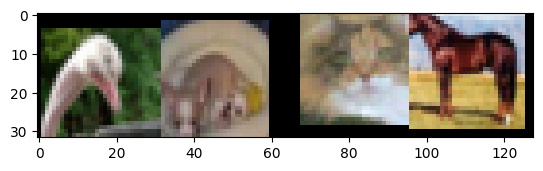

Class labels:  bird  dog   cat   horse


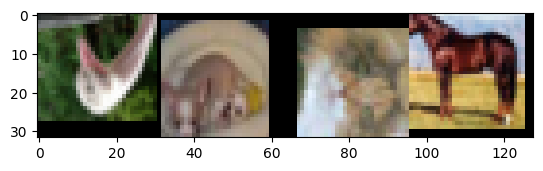

Rotation labels:  180   0     270   0    


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

In [ ]:
def run_test(net, testloader, criterion, task):
    net.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
                images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
                images, labels = images.to(device), cls_labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = total_loss / len(testloader)
    accuracy = 100 * correct / total

    print('TESTING:')
    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the test images: {avg_test_loss:.3f}')

    return avg_test_loss, accuracy

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

### In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=1e-1)

In [ ]:
from tqdm import tqdm
import time

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task, trainloader, testloader, model_path):
    lowest_loss = float('inf')
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()
        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'), 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item()
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(trainloader)
        avg_acc = 100 * running_correct / running_total
        print(f'\nEpoch {epoch+1} finished: Avg. Loss: {avg_loss:.3f}, Avg. Acc.: {avg_acc:.2f}%, Time: {time.time() - start_time:.2f}s')

        net.eval()
        test_loss, test_accuracy = run_test(net, testloader, criterion, task)
        if test_loss < lowest_loss:
            lowest_loss = test_loss
            best_accuracy = test_accuracy
            print(f'New lowest test loss: {lowest_loss:.4f} with accuracy: {best_accuracy:.2f}%')

            torch.save(net.state_dict(), model_path)

    print(f'Finished Training. Best Test Loss: {lowest_loss:.4f}, Best Accuracy: {best_accuracy:.2f}%')

In [ ]:
model_path = '/content/assignment3/assignment3/assignment3_part1/resnet18_rotation_task_best_model.pth'

train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation', trainloader=trainloader, testloader=testloader, model_path=model_path)

Epoch 1/45: 100%|██████████| 391/391 [00:14<00:00, 26.88batch/s]


Epoch 1 finished: Avg. Loss: 1.264, Avg. Acc.: 44.42%, Time: 14.55s


TESTING:
Accuracy of the network on the test images: 50.65 %
Average loss on the test images: 1.144
New lowest test loss: 1.1441 with accuracy: 50.65%


Epoch 2/45: 100%|██████████| 391/391 [00:12<00:00, 32.06batch/s]


Epoch 2 finished: Avg. Loss: 1.088, Avg. Acc.: 52.61%, Time: 12.20s


TESTING:
Accuracy of the network on the test images: 55.10 %
Average loss on the test images: 1.060
New lowest test loss: 1.0602 with accuracy: 55.10%


Epoch 3/45: 100%|██████████| 391/391 [00:12<00:00, 32.34batch/s]


Epoch 3 finished: Avg. Loss: 1.051, Avg. Acc.: 54.91%, Time: 12.09s


TESTING:
Accuracy of the network on the test images: 55.49 %
Average loss on the test images: 1.056
New lowest test loss: 1.0562 with accuracy: 55.49%


Epoch 4/45: 100%|██████████| 391/391 [00:11<00:00, 33.63batch/s]


Epoch 4 finished: Avg. Loss: 1.017, Avg. Acc.: 56.49%, Time: 11.63s


TESTING:
Accuracy of the network on the test images: 58.08 %
Average loss on the test images: 0.990
New lowest test loss: 0.9904 with accuracy: 58.08%


Epoch 5/45: 100%|██████████| 391/391 [00:11<00:00, 33.12batch/s]


Epoch 5 finished: Avg. Loss: 0.995, Avg. Acc.: 57.93%, Time: 11.81s


TESTING:
Accuracy of the network on the test images: 57.62 %
Average loss on the test images: 0.989
New lowest test loss: 0.9890 with accuracy: 57.62%


Epoch 6/45: 100%|██████████| 391/391 [00:11<00:00, 32.78batch/s]


Epoch 6 finished: Avg. Loss: 0.977, Avg. Acc.: 58.87%, Time: 11.93s


TESTING:
Accuracy of the network on the test images: 56.47 %
Average loss on the test images: 1.023


Epoch 7/45: 100%|██████████| 391/391 [00:11<00:00, 33.04batch/s]


Epoch 7 finished: Avg. Loss: 0.964, Avg. Acc.: 59.26%, Time: 11.84s


TESTING:
Accuracy of the network on the test images: 57.97 %
Average loss on the test images: 1.026


Epoch 8/45: 100%|██████████| 391/391 [00:11<00:00, 33.16batch/s]


Epoch 8 finished: Avg. Loss: 0.956, Avg. Acc.: 59.61%, Time: 11.80s


TESTING:
Accuracy of the network on the test images: 54.17 %
Average loss on the test images: 1.137


Epoch 9/45: 100%|██████████| 391/391 [00:11<00:00, 32.62batch/s]


Epoch 9 finished: Avg. Loss: 0.945, Avg. Acc.: 60.16%, Time: 11.99s


TESTING:
Accuracy of the network on the test images: 58.30 %
Average loss on the test images: 1.039


Epoch 10/45: 100%|██████████| 391/391 [00:11<00:00, 32.80batch/s]


Epoch 10 finished: Avg. Loss: 0.942, Avg. Acc.: 60.65%, Time: 11.93s


TESTING:
Accuracy of the network on the test images: 59.47 %
Average loss on the test images: 0.957
New lowest test loss: 0.9572 with accuracy: 59.47%


Epoch 11/45: 100%|██████████| 391/391 [00:11<00:00, 33.30batch/s]


Epoch 11 finished: Avg. Loss: 0.933, Avg. Acc.: 60.87%, Time: 11.75s


TESTING:
Accuracy of the network on the test images: 62.17 %
Average loss on the test images: 0.921
New lowest test loss: 0.9214 with accuracy: 62.17%


Epoch 12/45: 100%|██████████| 391/391 [00:11<00:00, 32.95batch/s]


Epoch 12 finished: Avg. Loss: 0.924, Avg. Acc.: 61.39%, Time: 11.87s


TESTING:
Accuracy of the network on the test images: 59.81 %
Average loss on the test images: 0.960


Epoch 13/45: 100%|██████████| 391/391 [00:11<00:00, 33.02batch/s]


Epoch 13 finished: Avg. Loss: 0.923, Avg. Acc.: 61.33%, Time: 11.85s


TESTING:
Accuracy of the network on the test images: 55.64 %
Average loss on the test images: 1.166


Epoch 14/45: 100%|██████████| 391/391 [00:11<00:00, 32.77batch/s]



Epoch 14 finished: Avg. Loss: 0.915, Avg. Acc.: 61.88%, Time: 11.94s
TESTING:
Accuracy of the network on the test images: 63.23 %
Average loss on the test images: 0.885
New lowest test loss: 0.8848 with accuracy: 63.23%


Epoch 15/45: 100%|██████████| 391/391 [00:11<00:00, 32.90batch/s]


Epoch 15 finished: Avg. Loss: 0.914, Avg. Acc.: 61.78%, Time: 11.89s


TESTING:
Accuracy of the network on the test images: 60.85 %
Average loss on the test images: 0.923


Epoch 16/45: 100%|██████████| 391/391 [00:11<00:00, 32.90batch/s]


Epoch 16 finished: Avg. Loss: 0.815, Avg. Acc.: 66.67%, Time: 11.89s


TESTING:
Accuracy of the network on the test images: 68.79 %
Average loss on the test images: 0.759
New lowest test loss: 0.7589 with accuracy: 68.79%


Epoch 17/45: 100%|██████████| 391/391 [00:11<00:00, 33.63batch/s]


Epoch 17 finished: Avg. Loss: 0.779, Avg. Acc.: 68.07%, Time: 11.63s


TESTING:
Accuracy of the network on the test images: 69.72 %
Average loss on the test images: 0.740
New lowest test loss: 0.7403 with accuracy: 69.72%


Epoch 18/45: 100%|██████████| 391/391 [00:11<00:00, 33.13batch/s]


Epoch 18 finished: Avg. Loss: 0.761, Avg. Acc.: 68.93%, Time: 11.81s


TESTING:
Accuracy of the network on the test images: 70.63 %
Average loss on the test images: 0.725
New lowest test loss: 0.7246 with accuracy: 70.63%


Epoch 19/45: 100%|██████████| 391/391 [00:11<00:00, 32.85batch/s]


Epoch 19 finished: Avg. Loss: 0.748, Avg. Acc.: 69.58%, Time: 11.91s


TESTING:
Accuracy of the network on the test images: 70.74 %
Average loss on the test images: 0.720
New lowest test loss: 0.7195 with accuracy: 70.74%


Epoch 20/45: 100%|██████████| 391/391 [00:11<00:00, 33.04batch/s]


Epoch 20 finished: Avg. Loss: 0.735, Avg. Acc.: 70.33%, Time: 11.84s


TESTING:
Accuracy of the network on the test images: 71.68 %
Average loss on the test images: 0.701
New lowest test loss: 0.7009 with accuracy: 71.68%


Epoch 21/45: 100%|██████████| 391/391 [00:11<00:00, 33.09batch/s]


Epoch 21 finished: Avg. Loss: 0.722, Avg. Acc.: 70.90%, Time: 11.82s


TESTING:
Accuracy of the network on the test images: 71.69 %
Average loss on the test images: 0.697
New lowest test loss: 0.6971 with accuracy: 71.69%


Epoch 22/45: 100%|██████████| 391/391 [00:12<00:00, 31.78batch/s]


Epoch 22 finished: Avg. Loss: 0.712, Avg. Acc.: 71.33%, Time: 12.31s


TESTING:
Accuracy of the network on the test images: 72.27 %
Average loss on the test images: 0.689
New lowest test loss: 0.6893 with accuracy: 72.27%


Epoch 23/45: 100%|██████████| 391/391 [00:11<00:00, 32.64batch/s]


Epoch 23 finished: Avg. Loss: 0.707, Avg. Acc.: 71.60%, Time: 11.98s


TESTING:
Accuracy of the network on the test images: 71.92 %
Average loss on the test images: 0.706


Epoch 24/45: 100%|██████████| 391/391 [00:11<00:00, 32.58batch/s]


Epoch 24 finished: Avg. Loss: 0.701, Avg. Acc.: 71.70%, Time: 12.00s


TESTING:
Accuracy of the network on the test images: 72.91 %
Average loss on the test images: 0.679
New lowest test loss: 0.6785 with accuracy: 72.91%


Epoch 25/45: 100%|██████████| 391/391 [00:11<00:00, 32.60batch/s]


Epoch 25 finished: Avg. Loss: 0.691, Avg. Acc.: 72.23%, Time: 12.00s


TESTING:
Accuracy of the network on the test images: 73.26 %
Average loss on the test images: 0.668
New lowest test loss: 0.6679 with accuracy: 73.26%


Epoch 26/45: 100%|██████████| 391/391 [00:11<00:00, 33.24batch/s]


Epoch 26 finished: Avg. Loss: 0.682, Avg. Acc.: 72.50%, Time: 11.77s


TESTING:
Accuracy of the network on the test images: 73.74 %
Average loss on the test images: 0.658
New lowest test loss: 0.6582 with accuracy: 73.74%


Epoch 27/45: 100%|██████████| 391/391 [00:11<00:00, 32.86batch/s]


Epoch 27 finished: Avg. Loss: 0.677, Avg. Acc.: 72.96%, Time: 11.90s


TESTING:
Accuracy of the network on the test images: 74.00 %
Average loss on the test images: 0.655
New lowest test loss: 0.6546 with accuracy: 74.00%


Epoch 28/45: 100%|██████████| 391/391 [00:11<00:00, 33.20batch/s]


Epoch 28 finished: Avg. Loss: 0.670, Avg. Acc.: 73.32%, Time: 11.78s


TESTING:
Accuracy of the network on the test images: 73.99 %
Average loss on the test images: 0.654
New lowest test loss: 0.6537 with accuracy: 73.99%


Epoch 29/45: 100%|██████████| 391/391 [00:11<00:00, 33.06batch/s]


Epoch 29 finished: Avg. Loss: 0.663, Avg. Acc.: 73.52%, Time: 11.83s


TESTING:
Accuracy of the network on the test images: 73.57 %
Average loss on the test images: 0.659


Epoch 30/45: 100%|██████████| 391/391 [00:11<00:00, 33.42batch/s]


Epoch 30 finished: Avg. Loss: 0.660, Avg. Acc.: 73.74%, Time: 11.71s


TESTING:
Accuracy of the network on the test images: 73.57 %
Average loss on the test images: 0.656


Epoch 31/45: 100%|██████████| 391/391 [00:11<00:00, 33.13batch/s]


Epoch 31 finished: Avg. Loss: 0.627, Avg. Acc.: 75.24%, Time: 11.81s


TESTING:
Accuracy of the network on the test images: 75.98 %
Average loss on the test images: 0.601
New lowest test loss: 0.6013 with accuracy: 75.98%


Epoch 32/45: 100%|██████████| 391/391 [00:11<00:00, 32.92batch/s]


Epoch 32 finished: Avg. Loss: 0.614, Avg. Acc.: 76.01%, Time: 11.88s


TESTING:
Accuracy of the network on the test images: 76.26 %
Average loss on the test images: 0.598
New lowest test loss: 0.5982 with accuracy: 76.26%


Epoch 33/45: 100%|██████████| 391/391 [00:11<00:00, 32.96batch/s]


Epoch 33 finished: Avg. Loss: 0.611, Avg. Acc.: 75.99%, Time: 11.87s


TESTING:
Accuracy of the network on the test images: 76.80 %
Average loss on the test images: 0.590
New lowest test loss: 0.5902 with accuracy: 76.80%


Epoch 34/45: 100%|██████████| 391/391 [00:12<00:00, 32.32batch/s]


Epoch 34 finished: Avg. Loss: 0.609, Avg. Acc.: 75.93%, Time: 12.10s


TESTING:
Accuracy of the network on the test images: 76.77 %
Average loss on the test images: 0.591


Epoch 35/45: 100%|██████████| 391/391 [00:11<00:00, 33.24batch/s]


Epoch 35 finished: Avg. Loss: 0.605, Avg. Acc.: 76.04%, Time: 11.77s


TESTING:
Accuracy of the network on the test images: 76.76 %
Average loss on the test images: 0.587
New lowest test loss: 0.5874 with accuracy: 76.76%


Epoch 36/45: 100%|██████████| 391/391 [00:11<00:00, 32.94batch/s]


Epoch 36 finished: Avg. Loss: 0.600, Avg. Acc.: 76.52%, Time: 11.88s


TESTING:
Accuracy of the network on the test images: 76.94 %
Average loss on the test images: 0.586
New lowest test loss: 0.5856 with accuracy: 76.94%


Epoch 37/45: 100%|██████████| 391/391 [00:11<00:00, 32.81batch/s]


Epoch 37 finished: Avg. Loss: 0.602, Avg. Acc.: 76.37%, Time: 11.92s


TESTING:
Accuracy of the network on the test images: 76.72 %
Average loss on the test images: 0.587


Epoch 38/45: 100%|██████████| 391/391 [00:11<00:00, 33.09batch/s]


Epoch 38 finished: Avg. Loss: 0.600, Avg. Acc.: 76.41%, Time: 11.82s


TESTING:
Accuracy of the network on the test images: 77.00 %
Average loss on the test images: 0.588


Epoch 39/45: 100%|██████████| 391/391 [00:11<00:00, 32.94batch/s]


Epoch 39 finished: Avg. Loss: 0.597, Avg. Acc.: 76.65%, Time: 11.87s


TESTING:
Accuracy of the network on the test images: 76.86 %
Average loss on the test images: 0.587


Epoch 40/45: 100%|██████████| 391/391 [00:11<00:00, 32.99batch/s]


Epoch 40 finished: Avg. Loss: 0.596, Avg. Acc.: 76.72%, Time: 11.86s


TESTING:
Accuracy of the network on the test images: 76.99 %
Average loss on the test images: 0.587


Epoch 41/45: 100%|██████████| 391/391 [00:11<00:00, 32.73batch/s]


Epoch 41 finished: Avg. Loss: 0.590, Avg. Acc.: 76.71%, Time: 11.95s


TESTING:
Accuracy of the network on the test images: 77.05 %
Average loss on the test images: 0.582
New lowest test loss: 0.5815 with accuracy: 77.05%


Epoch 42/45: 100%|██████████| 391/391 [00:11<00:00, 32.93batch/s]


Epoch 42 finished: Avg. Loss: 0.592, Avg. Acc.: 76.76%, Time: 11.88s


TESTING:
Accuracy of the network on the test images: 77.01 %
Average loss on the test images: 0.586


Epoch 43/45: 100%|██████████| 391/391 [00:12<00:00, 32.25batch/s]


Epoch 43 finished: Avg. Loss: 0.590, Avg. Acc.: 76.82%, Time: 12.13s


TESTING:
Accuracy of the network on the test images: 77.13 %
Average loss on the test images: 0.578
New lowest test loss: 0.5782 with accuracy: 77.13%


Epoch 44/45: 100%|██████████| 391/391 [00:12<00:00, 32.44batch/s]


Epoch 44 finished: Avg. Loss: 0.588, Avg. Acc.: 76.93%, Time: 12.06s


TESTING:
Accuracy of the network on the test images: 77.46 %
Average loss on the test images: 0.576
New lowest test loss: 0.5760 with accuracy: 77.46%


Epoch 45/45: 100%|██████████| 391/391 [00:12<00:00, 32.51batch/s]


Epoch 45 finished: Avg. Loss: 0.590, Avg. Acc.: 76.83%, Time: 12.03s


TESTING:
Accuracy of the network on the test images: 77.27 %
Average loss on the test images: 0.577
Finished Training. Best Test Loss: 0.5760, Best Accuracy: 77.46%


# Fine-tuning on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
from typing_extensions import NewType
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

path = '/content/assignment3/assignment3/assignment3_part1/resnet18_rotation_task_best_model.pth'

net = resnet18(pretrained=False)
pretrained_dict = torch.load(path)
net_dict = net.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net_dict and net_dict[k].size() == v.size()}
# 2. overwrite entries in the existing state dict
net_dict.update(pretrained_dict)
# 3. load the new state dict
net.load_state_dict(net_dict)

num_ftrs = net.fc.in_features
NewType.fc = nn.Linear(num_ftrs, 10)

net = net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
for param in net.parameters():
    param.requires_grad = False

for param in net.layer4.parameters():
    param.requires_grad = True

for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01, weight_decay=1e-1)

In [ ]:
model_path = '/content/assignment3/assignment3/assignment3_part1/resnet18_finetune_classification_task_best_model.pth'

train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification', trainloader=trainloader, testloader=testloader, model_path=model_path)

Epoch 1/20: 100%|██████████| 391/391 [00:11<00:00, 33.43batch/s]


Epoch 1 finished: Avg. Loss: 1.717, Avg. Acc.: 39.55%, Time: 11.70s


TESTING:
Accuracy of the network on the test images: 42.63 %
Average loss on the test images: 1.584
New lowest test loss: 1.5845 with accuracy: 42.63%


Epoch 2/20: 100%|██████████| 391/391 [00:11<00:00, 33.97batch/s]


Epoch 2 finished: Avg. Loss: 1.478, Avg. Acc.: 46.39%, Time: 11.51s


TESTING:
Accuracy of the network on the test images: 45.77 %
Average loss on the test images: 1.491
New lowest test loss: 1.4906 with accuracy: 45.77%


Epoch 3/20: 100%|██████████| 391/391 [00:11<00:00, 33.88batch/s]


Epoch 3 finished: Avg. Loss: 1.463, Avg. Acc.: 46.91%, Time: 11.55s


TESTING:
Accuracy of the network on the test images: 48.65 %
Average loss on the test images: 1.439
New lowest test loss: 1.4391 with accuracy: 48.65%


Epoch 4/20: 100%|██████████| 391/391 [00:11<00:00, 33.72batch/s]


Epoch 4 finished: Avg. Loss: 1.450, Avg. Acc.: 47.53%, Time: 11.60s


TESTING:
Accuracy of the network on the test images: 44.02 %
Average loss on the test images: 1.577


Epoch 5/20: 100%|██████████| 391/391 [00:11<00:00, 34.21batch/s]


Epoch 5 finished: Avg. Loss: 1.443, Avg. Acc.: 47.65%, Time: 11.43s


TESTING:
Accuracy of the network on the test images: 47.52 %
Average loss on the test images: 1.455


Epoch 6/20: 100%|██████████| 391/391 [00:11<00:00, 34.72batch/s]


Epoch 6 finished: Avg. Loss: 1.445, Avg. Acc.: 47.61%, Time: 11.27s


TESTING:
Accuracy of the network on the test images: 45.96 %
Average loss on the test images: 1.477


Epoch 7/20: 100%|██████████| 391/391 [00:11<00:00, 34.38batch/s]


Epoch 7 finished: Avg. Loss: 1.441, Avg. Acc.: 47.78%, Time: 11.38s


TESTING:
Accuracy of the network on the test images: 48.85 %
Average loss on the test images: 1.436
New lowest test loss: 1.4365 with accuracy: 48.85%


Epoch 8/20: 100%|██████████| 391/391 [00:11<00:00, 34.82batch/s]


Epoch 8 finished: Avg. Loss: 1.431, Avg. Acc.: 48.12%, Time: 11.23s


TESTING:
Accuracy of the network on the test images: 47.77 %
Average loss on the test images: 1.487


Epoch 9/20: 100%|██████████| 391/391 [00:11<00:00, 35.14batch/s]


Epoch 9 finished: Avg. Loss: 1.438, Avg. Acc.: 48.03%, Time: 11.13s


TESTING:
Accuracy of the network on the test images: 47.81 %
Average loss on the test images: 1.466


Epoch 10/20: 100%|██████████| 391/391 [00:11<00:00, 35.23batch/s]


Epoch 10 finished: Avg. Loss: 1.431, Avg. Acc.: 48.18%, Time: 11.10s


TESTING:
Accuracy of the network on the test images: 48.93 %
Average loss on the test images: 1.432
New lowest test loss: 1.4316 with accuracy: 48.93%


Epoch 11/20: 100%|██████████| 391/391 [00:11<00:00, 34.88batch/s]


Epoch 11 finished: Avg. Loss: 1.350, Avg. Acc.: 51.19%, Time: 11.21s


TESTING:
Accuracy of the network on the test images: 52.70 %
Average loss on the test images: 1.317
New lowest test loss: 1.3168 with accuracy: 52.70%


Epoch 12/20: 100%|██████████| 391/391 [00:11<00:00, 34.19batch/s]


Epoch 12 finished: Avg. Loss: 1.325, Avg. Acc.: 52.29%, Time: 11.44s


TESTING:
Accuracy of the network on the test images: 53.45 %
Average loss on the test images: 1.293
New lowest test loss: 1.2935 with accuracy: 53.45%


Epoch 13/20: 100%|██████████| 391/391 [00:11<00:00, 33.76batch/s]


Epoch 13 finished: Avg. Loss: 1.314, Avg. Acc.: 52.65%, Time: 11.59s


TESTING:
Accuracy of the network on the test images: 54.40 %
Average loss on the test images: 1.277
New lowest test loss: 1.2773 with accuracy: 54.40%


Epoch 14/20: 100%|██████████| 391/391 [00:11<00:00, 33.82batch/s]


Epoch 14 finished: Avg. Loss: 1.308, Avg. Acc.: 52.93%, Time: 11.57s


TESTING:
Accuracy of the network on the test images: 53.87 %
Average loss on the test images: 1.274
New lowest test loss: 1.2735 with accuracy: 53.87%


Epoch 15/20: 100%|██████████| 391/391 [00:11<00:00, 34.06batch/s]


Epoch 15 finished: Avg. Loss: 1.305, Avg. Acc.: 52.89%, Time: 11.49s


TESTING:
Accuracy of the network on the test images: 53.99 %
Average loss on the test images: 1.270
New lowest test loss: 1.2697 with accuracy: 53.99%


Epoch 16/20: 100%|██████████| 391/391 [00:11<00:00, 34.16batch/s]


Epoch 16 finished: Avg. Loss: 1.303, Avg. Acc.: 53.24%, Time: 11.45s


TESTING:
Accuracy of the network on the test images: 54.31 %
Average loss on the test images: 1.267
New lowest test loss: 1.2672 with accuracy: 54.31%


Epoch 17/20: 100%|██████████| 391/391 [00:11<00:00, 34.33batch/s]


Epoch 17 finished: Avg. Loss: 1.296, Avg. Acc.: 53.45%, Time: 11.40s


TESTING:
Accuracy of the network on the test images: 55.00 %
Average loss on the test images: 1.255
New lowest test loss: 1.2547 with accuracy: 55.00%


Epoch 18/20: 100%|██████████| 391/391 [00:11<00:00, 33.93batch/s]


Epoch 18 finished: Avg. Loss: 1.288, Avg. Acc.: 53.77%, Time: 11.53s


TESTING:
Accuracy of the network on the test images: 54.54 %
Average loss on the test images: 1.260


Epoch 19/20: 100%|██████████| 391/391 [00:11<00:00, 34.71batch/s]


Epoch 19 finished: Avg. Loss: 1.288, Avg. Acc.: 53.29%, Time: 11.27s


TESTING:
Accuracy of the network on the test images: 54.52 %
Average loss on the test images: 1.261


Epoch 20/20: 100%|██████████| 391/391 [00:11<00:00, 34.53batch/s]


Epoch 20 finished: Avg. Loss: 1.284, Avg. Acc.: 53.68%, Time: 11.33s


TESTING:
Accuracy of the network on the test images: 54.71 %
Average loss on the test images: 1.250
New lowest test loss: 1.2501 with accuracy: 54.71%
Finished Training. Best Test Loss: 1.2501, Best Accuracy: 54.71%


# Fine-tuning on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
model = resnet18(pretrained=False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True


model = model.to(device)

In [ ]:
# Print all the trainable parameters
params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, weight_decay=1e-1)

In [ ]:
model_path = '/content/assignment3/assignment3/assignment3_part1/resnet18_random_classification_task_best_model.pth'

train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification', trainloader=trainloader, testloader=testloader, model_path=model_path)

Epoch 1/20: 100%|██████████| 391/391 [00:11<00:00, 35.38batch/s]


Epoch 1 finished: Avg. Loss: 1.940, Avg. Acc.: 30.77%, Time: 11.06s


TESTING:
Accuracy of the network on the test images: 35.64 %
Average loss on the test images: 1.744
New lowest test loss: 1.7439 with accuracy: 35.64%


Epoch 2/20: 100%|██████████| 391/391 [00:11<00:00, 34.66batch/s]


Epoch 2 finished: Avg. Loss: 1.779, Avg. Acc.: 35.32%, Time: 11.29s


TESTING:
Accuracy of the network on the test images: 38.27 %
Average loss on the test images: 1.707
New lowest test loss: 1.7074 with accuracy: 38.27%


Epoch 3/20: 100%|██████████| 391/391 [00:11<00:00, 33.87batch/s]


Epoch 3 finished: Avg. Loss: 1.753, Avg. Acc.: 36.31%, Time: 11.55s


TESTING:
Accuracy of the network on the test images: 37.84 %
Average loss on the test images: 1.705
New lowest test loss: 1.7054 with accuracy: 37.84%


Epoch 4/20: 100%|██████████| 391/391 [00:11<00:00, 33.48batch/s]


Epoch 4 finished: Avg. Loss: 1.743, Avg. Acc.: 36.49%, Time: 11.68s


TESTING:
Accuracy of the network on the test images: 39.82 %
Average loss on the test images: 1.680
New lowest test loss: 1.6801 with accuracy: 39.82%


Epoch 5/20: 100%|██████████| 391/391 [00:11<00:00, 33.61batch/s]


Epoch 5 finished: Avg. Loss: 1.734, Avg. Acc.: 36.74%, Time: 11.64s


TESTING:
Accuracy of the network on the test images: 38.01 %
Average loss on the test images: 1.686


Epoch 6/20: 100%|██████████| 391/391 [00:11<00:00, 33.61batch/s]


Epoch 6 finished: Avg. Loss: 1.729, Avg. Acc.: 37.15%, Time: 11.64s


TESTING:
Accuracy of the network on the test images: 38.73 %
Average loss on the test images: 1.674
New lowest test loss: 1.6738 with accuracy: 38.73%


Epoch 7/20: 100%|██████████| 391/391 [00:11<00:00, 32.82batch/s]


Epoch 7 finished: Avg. Loss: 1.722, Avg. Acc.: 37.68%, Time: 11.92s


TESTING:
Accuracy of the network on the test images: 39.85 %
Average loss on the test images: 1.682


Epoch 8/20: 100%|██████████| 391/391 [00:11<00:00, 33.26batch/s]


Epoch 8 finished: Avg. Loss: 1.719, Avg. Acc.: 37.63%, Time: 11.76s


TESTING:
Accuracy of the network on the test images: 39.67 %
Average loss on the test images: 1.670
New lowest test loss: 1.6698 with accuracy: 39.67%


Epoch 9/20: 100%|██████████| 391/391 [00:11<00:00, 33.37batch/s]


Epoch 9 finished: Avg. Loss: 1.717, Avg. Acc.: 37.71%, Time: 11.72s


TESTING:
Accuracy of the network on the test images: 40.25 %
Average loss on the test images: 1.656
New lowest test loss: 1.6562 with accuracy: 40.25%


Epoch 10/20: 100%|██████████| 391/391 [00:11<00:00, 33.04batch/s]


Epoch 10 finished: Avg. Loss: 1.714, Avg. Acc.: 37.92%, Time: 11.84s


TESTING:
Accuracy of the network on the test images: 39.52 %
Average loss on the test images: 1.659


Epoch 11/20: 100%|██████████| 391/391 [00:11<00:00, 33.35batch/s]


Epoch 11 finished: Avg. Loss: 1.657, Avg. Acc.: 40.11%, Time: 11.73s


TESTING:
Accuracy of the network on the test images: 43.14 %
Average loss on the test images: 1.572
New lowest test loss: 1.5720 with accuracy: 43.14%


Epoch 12/20: 100%|██████████| 391/391 [00:11<00:00, 33.39batch/s]


Epoch 12 finished: Avg. Loss: 1.623, Avg. Acc.: 41.57%, Time: 11.71s


TESTING:
Accuracy of the network on the test images: 44.03 %
Average loss on the test images: 1.561
New lowest test loss: 1.5612 with accuracy: 44.03%


Epoch 13/20: 100%|██████████| 391/391 [00:11<00:00, 32.98batch/s]


Epoch 13 finished: Avg. Loss: 1.606, Avg. Acc.: 41.87%, Time: 11.86s


TESTING:
Accuracy of the network on the test images: 44.57 %
Average loss on the test images: 1.548
New lowest test loss: 1.5475 with accuracy: 44.57%


Epoch 14/20: 100%|██████████| 391/391 [00:11<00:00, 32.98batch/s]


Epoch 14 finished: Avg. Loss: 1.594, Avg. Acc.: 42.45%, Time: 11.86s


TESTING:
Accuracy of the network on the test images: 44.34 %
Average loss on the test images: 1.541
New lowest test loss: 1.5413 with accuracy: 44.34%


Epoch 15/20: 100%|██████████| 391/391 [00:11<00:00, 32.95batch/s]


Epoch 15 finished: Avg. Loss: 1.587, Avg. Acc.: 42.65%, Time: 11.87s


TESTING:
Accuracy of the network on the test images: 44.94 %
Average loss on the test images: 1.537
New lowest test loss: 1.5370 with accuracy: 44.94%


Epoch 16/20: 100%|██████████| 391/391 [00:11<00:00, 33.23batch/s]


Epoch 16 finished: Avg. Loss: 1.587, Avg. Acc.: 42.73%, Time: 11.77s


TESTING:
Accuracy of the network on the test images: 45.23 %
Average loss on the test images: 1.534
New lowest test loss: 1.5337 with accuracy: 45.23%


Epoch 17/20: 100%|██████████| 391/391 [00:11<00:00, 32.95batch/s]


Epoch 17 finished: Avg. Loss: 1.575, Avg. Acc.: 43.22%, Time: 11.87s


TESTING:
Accuracy of the network on the test images: 45.24 %
Average loss on the test images: 1.529
New lowest test loss: 1.5289 with accuracy: 45.24%


Epoch 18/20: 100%|██████████| 391/391 [00:11<00:00, 32.91batch/s]


Epoch 18 finished: Avg. Loss: 1.570, Avg. Acc.: 43.46%, Time: 11.89s


TESTING:
Accuracy of the network on the test images: 45.28 %
Average loss on the test images: 1.522
New lowest test loss: 1.5216 with accuracy: 45.28%


Epoch 19/20: 100%|██████████| 391/391 [00:11<00:00, 33.35batch/s]


Epoch 19 finished: Avg. Loss: 1.565, Avg. Acc.: 43.79%, Time: 11.73s


TESTING:
Accuracy of the network on the test images: 45.54 %
Average loss on the test images: 1.524


Epoch 20/20: 100%|██████████| 391/391 [00:11<00:00, 32.60batch/s]


Epoch 20 finished: Avg. Loss: 1.558, Avg. Acc.: 43.97%, Time: 12.00s


TESTING:
Accuracy of the network on the test images: 45.68 %
Average loss on the test images: 1.518
New lowest test loss: 1.5175 with accuracy: 45.68%
Finished Training. Best Test Loss: 1.5175, Best Accuracy: 45.68%


# Supervised training on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
from typing_extensions import NewType
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

path = '/content/assignment3/assignment3/assignment3_part1/resnet18_rotation_task_best_model.pth'

net = resnet18(pretrained=False)
pretrained_dict = torch.load(path)

num_ftrs = net.fc.in_features
NewType.fc = nn.Linear(num_ftrs, 10)

net = net.to(device)

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01, weight_decay=1e-1)

In [ ]:
model_path = '/content/assignment3/assignment3/assignment3_part1/resnet18_finetune_full_classification_task_best_model.pth'

train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification', trainloader=trainloader, testloader=testloader, model_path=model_path)

Epoch 1/20: 100%|██████████| 391/391 [00:12<00:00, 32.03batch/s]


Epoch 1 finished: Avg. Loss: 1.816, Avg. Acc.: 35.02%, Time: 12.21s


TESTING:
Accuracy of the network on the test images: 38.63 %
Average loss on the test images: 1.786
New lowest test loss: 1.7858 with accuracy: 38.63%


Epoch 2/20: 100%|██████████| 391/391 [00:12<00:00, 31.92batch/s]


Epoch 2 finished: Avg. Loss: 1.390, Avg. Acc.: 49.79%, Time: 12.25s


TESTING:
Accuracy of the network on the test images: 54.72 %
Average loss on the test images: 1.266
New lowest test loss: 1.2655 with accuracy: 54.72%


Epoch 3/20: 100%|██████████| 391/391 [00:12<00:00, 31.81batch/s]


Epoch 3 finished: Avg. Loss: 1.195, Avg. Acc.: 57.65%, Time: 12.30s


TESTING:
Accuracy of the network on the test images: 57.63 %
Average loss on the test images: 1.232
New lowest test loss: 1.2318 with accuracy: 57.63%


Epoch 4/20: 100%|██████████| 391/391 [00:11<00:00, 32.68batch/s]


Epoch 4 finished: Avg. Loss: 1.100, Avg. Acc.: 61.36%, Time: 11.97s


TESTING:
Accuracy of the network on the test images: 58.30 %
Average loss on the test images: 1.200
New lowest test loss: 1.2000 with accuracy: 58.30%


Epoch 5/20: 100%|██████████| 391/391 [00:12<00:00, 32.19batch/s]


Epoch 5 finished: Avg. Loss: 1.035, Avg. Acc.: 63.94%, Time: 12.15s


TESTING:
Accuracy of the network on the test images: 62.50 %
Average loss on the test images: 1.108
New lowest test loss: 1.1076 with accuracy: 62.50%


Epoch 6/20: 100%|██████████| 391/391 [00:12<00:00, 32.20batch/s]


Epoch 6 finished: Avg. Loss: 0.978, Avg. Acc.: 66.03%, Time: 12.15s


TESTING:
Accuracy of the network on the test images: 62.13 %
Average loss on the test images: 1.152


Epoch 7/20: 100%|██████████| 391/391 [00:12<00:00, 32.33batch/s]


Epoch 7 finished: Avg. Loss: 0.949, Avg. Acc.: 67.07%, Time: 12.10s


TESTING:
Accuracy of the network on the test images: 65.92 %
Average loss on the test images: 1.011
New lowest test loss: 1.0113 with accuracy: 65.92%


Epoch 8/20: 100%|██████████| 391/391 [00:12<00:00, 32.19batch/s]


Epoch 8 finished: Avg. Loss: 0.930, Avg. Acc.: 67.83%, Time: 12.15s


TESTING:
Accuracy of the network on the test images: 64.62 %
Average loss on the test images: 1.012


Epoch 9/20: 100%|██████████| 391/391 [00:12<00:00, 32.05batch/s]


Epoch 9 finished: Avg. Loss: 0.909, Avg. Acc.: 68.67%, Time: 12.21s


TESTING:
Accuracy of the network on the test images: 69.88 %
Average loss on the test images: 0.872
New lowest test loss: 0.8722 with accuracy: 69.88%


Epoch 10/20: 100%|██████████| 391/391 [00:11<00:00, 32.93batch/s]


Epoch 10 finished: Avg. Loss: 0.900, Avg. Acc.: 68.85%, Time: 11.88s


TESTING:
Accuracy of the network on the test images: 70.08 %
Average loss on the test images: 0.875


Epoch 11/20: 100%|██████████| 391/391 [00:11<00:00, 33.66batch/s]


Epoch 11 finished: Avg. Loss: 0.666, Avg. Acc.: 76.99%, Time: 11.62s


TESTING:
Accuracy of the network on the test images: 78.23 %
Average loss on the test images: 0.619
New lowest test loss: 0.6189 with accuracy: 78.23%


Epoch 12/20: 100%|██████████| 391/391 [00:11<00:00, 33.41batch/s]


Epoch 12 finished: Avg. Loss: 0.597, Avg. Acc.: 79.52%, Time: 11.71s


TESTING:
Accuracy of the network on the test images: 79.22 %
Average loss on the test images: 0.590
New lowest test loss: 0.5901 with accuracy: 79.22%


Epoch 13/20: 100%|██████████| 391/391 [00:11<00:00, 33.13batch/s]


Epoch 13 finished: Avg. Loss: 0.566, Avg. Acc.: 80.35%, Time: 11.81s


TESTING:
Accuracy of the network on the test images: 80.31 %
Average loss on the test images: 0.580
New lowest test loss: 0.5805 with accuracy: 80.31%


Epoch 14/20: 100%|██████████| 391/391 [00:11<00:00, 33.13batch/s]


Epoch 14 finished: Avg. Loss: 0.542, Avg. Acc.: 81.14%, Time: 11.81s


TESTING:
Accuracy of the network on the test images: 80.76 %
Average loss on the test images: 0.557
New lowest test loss: 0.5571 with accuracy: 80.76%


Epoch 15/20: 100%|██████████| 391/391 [00:11<00:00, 32.85batch/s]


Epoch 15 finished: Avg. Loss: 0.525, Avg. Acc.: 82.00%, Time: 11.91s


TESTING:
Accuracy of the network on the test images: 80.64 %
Average loss on the test images: 0.553
New lowest test loss: 0.5527 with accuracy: 80.64%


Epoch 16/20: 100%|██████████| 391/391 [00:11<00:00, 33.37batch/s]


Epoch 16 finished: Avg. Loss: 0.509, Avg. Acc.: 82.33%, Time: 11.72s


TESTING:
Accuracy of the network on the test images: 81.42 %
Average loss on the test images: 0.542
New lowest test loss: 0.5423 with accuracy: 81.42%


Epoch 17/20: 100%|██████████| 391/391 [00:11<00:00, 33.15batch/s]


Epoch 17 finished: Avg. Loss: 0.492, Avg. Acc.: 83.11%, Time: 11.80s


TESTING:
Accuracy of the network on the test images: 81.94 %
Average loss on the test images: 0.525
New lowest test loss: 0.5246 with accuracy: 81.94%


Epoch 18/20: 100%|██████████| 391/391 [00:11<00:00, 32.84batch/s]


Epoch 18 finished: Avg. Loss: 0.478, Avg. Acc.: 83.38%, Time: 11.91s


TESTING:
Accuracy of the network on the test images: 81.11 %
Average loss on the test images: 0.548


Epoch 19/20: 100%|██████████| 391/391 [00:12<00:00, 32.55batch/s]


Epoch 19 finished: Avg. Loss: 0.471, Avg. Acc.: 83.64%, Time: 12.02s


TESTING:
Accuracy of the network on the test images: 81.74 %
Average loss on the test images: 0.531


Epoch 20/20: 100%|██████████| 391/391 [00:11<00:00, 33.34batch/s]


Epoch 20 finished: Avg. Loss: 0.458, Avg. Acc.: 84.21%, Time: 11.73s


TESTING:
Accuracy of the network on the test images: 81.12 %
Average loss on the test images: 0.548
Finished Training. Best Test Loss: 0.5246, Best Accuracy: 81.94%


# Supervised training on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
model = resnet18(pretrained=False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

In [ ]:
# Print all the trainable parameters
params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-1)

In [ ]:
model_path = '/content/assignment3/assignment3/assignment3_part1/resnet18_random_full_classification_task_best_model.pth'

train(model, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification', trainloader=trainloader, testloader=testloader, model_path=model_path)

Epoch 1/20: 100%|██████████| 391/391 [00:11<00:00, 32.66batch/s]


Epoch 1 finished: Avg. Loss: 1.857, Avg. Acc.: 32.91%, Time: 11.98s


TESTING:
Accuracy of the network on the test images: 43.11 %
Average loss on the test images: 1.552
New lowest test loss: 1.5517 with accuracy: 43.11%


Epoch 2/20: 100%|██████████| 391/391 [00:11<00:00, 32.82batch/s]


Epoch 2 finished: Avg. Loss: 1.428, Avg. Acc.: 47.76%, Time: 11.92s


TESTING:
Accuracy of the network on the test images: 45.54 %
Average loss on the test images: 1.582


Epoch 3/20: 100%|██████████| 391/391 [00:11<00:00, 32.91batch/s]



Epoch 3 finished: Avg. Loss: 1.231, Avg. Acc.: 55.90%, Time: 11.89s
TESTING:
Accuracy of the network on the test images: 57.52 %
Average loss on the test images: 1.228
New lowest test loss: 1.2276 with accuracy: 57.52%


Epoch 4/20: 100%|██████████| 391/391 [00:11<00:00, 32.78batch/s]


Epoch 4 finished: Avg. Loss: 1.117, Avg. Acc.: 60.33%, Time: 11.94s


TESTING:
Accuracy of the network on the test images: 59.41 %
Average loss on the test images: 1.210
New lowest test loss: 1.2105 with accuracy: 59.41%


Epoch 5/20: 100%|██████████| 391/391 [00:11<00:00, 32.72batch/s]


Epoch 5 finished: Avg. Loss: 1.043, Avg. Acc.: 63.25%, Time: 11.95s


TESTING:
Accuracy of the network on the test images: 62.73 %
Average loss on the test images: 1.127
New lowest test loss: 1.1273 with accuracy: 62.73%


Epoch 6/20: 100%|██████████| 391/391 [00:11<00:00, 33.04batch/s]


Epoch 6 finished: Avg. Loss: 0.999, Avg. Acc.: 65.20%, Time: 11.84s


TESTING:
Accuracy of the network on the test images: 66.76 %
Average loss on the test images: 0.952
New lowest test loss: 0.9521 with accuracy: 66.76%


Epoch 7/20: 100%|██████████| 391/391 [00:12<00:00, 32.40batch/s]


Epoch 7 finished: Avg. Loss: 0.965, Avg. Acc.: 66.60%, Time: 12.07s


TESTING:
Accuracy of the network on the test images: 64.37 %
Average loss on the test images: 1.070


Epoch 8/20: 100%|██████████| 391/391 [00:11<00:00, 33.41batch/s]


Epoch 8 finished: Avg. Loss: 0.944, Avg. Acc.: 67.47%, Time: 11.71s


TESTING:
Accuracy of the network on the test images: 64.45 %
Average loss on the test images: 1.061


Epoch 9/20: 100%|██████████| 391/391 [00:11<00:00, 33.58batch/s]


Epoch 9 finished: Avg. Loss: 0.927, Avg. Acc.: 67.95%, Time: 11.65s


TESTING:
Accuracy of the network on the test images: 63.74 %
Average loss on the test images: 1.053


Epoch 10/20: 100%|██████████| 391/391 [00:11<00:00, 33.09batch/s]


Epoch 10 finished: Avg. Loss: 0.912, Avg. Acc.: 68.72%, Time: 11.82s


TESTING:
Accuracy of the network on the test images: 69.09 %
Average loss on the test images: 0.904
New lowest test loss: 0.9036 with accuracy: 69.09%


Epoch 11/20: 100%|██████████| 391/391 [00:11<00:00, 32.61batch/s]


Epoch 11 finished: Avg. Loss: 0.692, Avg. Acc.: 76.14%, Time: 12.00s


TESTING:
Accuracy of the network on the test images: 78.05 %
Average loss on the test images: 0.630
New lowest test loss: 0.6301 with accuracy: 78.05%


Epoch 12/20: 100%|██████████| 391/391 [00:11<00:00, 32.89batch/s]


Epoch 12 finished: Avg. Loss: 0.617, Avg. Acc.: 78.47%, Time: 11.89s


TESTING:
Accuracy of the network on the test images: 79.09 %
Average loss on the test images: 0.602
New lowest test loss: 0.6019 with accuracy: 79.09%


Epoch 13/20: 100%|██████████| 391/391 [00:11<00:00, 32.70batch/s]


Epoch 13 finished: Avg. Loss: 0.587, Avg. Acc.: 79.73%, Time: 11.96s


TESTING:
Accuracy of the network on the test images: 79.89 %
Average loss on the test images: 0.590
New lowest test loss: 0.5903 with accuracy: 79.89%


Epoch 14/20: 100%|██████████| 391/391 [00:11<00:00, 32.94batch/s]


Epoch 14 finished: Avg. Loss: 0.566, Avg. Acc.: 80.33%, Time: 11.88s


TESTING:
Accuracy of the network on the test images: 79.87 %
Average loss on the test images: 0.579
New lowest test loss: 0.5787 with accuracy: 79.87%


Epoch 15/20: 100%|██████████| 391/391 [00:12<00:00, 32.49batch/s]


Epoch 15 finished: Avg. Loss: 0.547, Avg. Acc.: 80.90%, Time: 12.04s


TESTING:
Accuracy of the network on the test images: 80.46 %
Average loss on the test images: 0.565
New lowest test loss: 0.5650 with accuracy: 80.46%


Epoch 16/20: 100%|██████████| 391/391 [00:11<00:00, 32.85batch/s]


Epoch 16 finished: Avg. Loss: 0.529, Avg. Acc.: 81.70%, Time: 11.91s


TESTING:
Accuracy of the network on the test images: 80.57 %
Average loss on the test images: 0.557
New lowest test loss: 0.5568 with accuracy: 80.57%


Epoch 17/20: 100%|██████████| 391/391 [00:11<00:00, 32.85batch/s]


Epoch 17 finished: Avg. Loss: 0.514, Avg. Acc.: 82.19%, Time: 11.91s


TESTING:
Accuracy of the network on the test images: 80.80 %
Average loss on the test images: 0.559


Epoch 18/20: 100%|██████████| 391/391 [00:11<00:00, 33.08batch/s]


Epoch 18 finished: Avg. Loss: 0.498, Avg. Acc.: 82.78%, Time: 11.82s


TESTING:
Accuracy of the network on the test images: 81.17 %
Average loss on the test images: 0.538
New lowest test loss: 0.5381 with accuracy: 81.17%


Epoch 19/20: 100%|██████████| 391/391 [00:11<00:00, 33.43batch/s]


Epoch 19 finished: Avg. Loss: 0.488, Avg. Acc.: 83.18%, Time: 11.70s


TESTING:
Accuracy of the network on the test images: 81.26 %
Average loss on the test images: 0.536
New lowest test loss: 0.5359 with accuracy: 81.26%


Epoch 20/20: 100%|██████████| 391/391 [00:12<00:00, 32.46batch/s]


Epoch 20 finished: Avg. Loss: 0.477, Avg. Acc.: 83.26%, Time: 12.05s


TESTING:
Accuracy of the network on the test images: 81.72 %
Average loss on the test images: 0.538
Finished Training. Best Test Loss: 0.5359, Best Accuracy: 81.26%


---

# Extra Credit Part 1

## Vision Transformer from Scratch
### Fine-tune ViT on rotation task and then use pre-trained model for full classification task
#### *Note that I worked on this ViT from scratch over winter break and not just during this assignment*

In [ ]:
%%capture
!pip install fvcore
!pip install einops
!pip install pytorch-ignite
!pip install wandb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import argparse
import tqdm
import random
import os
import logging
import time
import wandb
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torchvision import datasets, transforms
from torch.optim import AdamW, Adam
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

from typing import Tuple, Optional, Callable, Iterable
from collections import defaultdict

from __future__ import division
from __future__ import unicode_literals

import weakref
import copy
import contextlib

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from functools import partial

from PIL import ImageFilter, ImageOps, Image
from fvcore.nn import FlopCountAnalysis, ActivationCountAnalysis, flop_count_table

from ignite.utils import convert_tensor

import warnings
warnings.filterwarnings("ignore")

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch Vision Transformer Model from Scratch')

parser.add_argument('--DATA_DIR', type=str, default='./data',
                    help='Data directory')
parser.add_argument('--BATCH_SIZE', type=int, default=128,
                    help='batch size')
parser.add_argument('--IMAGE_SIZE', type=int, default=32,
                    help='image size')
parser.add_argument('--EPOCHS', type=int, default=60,
                    help='number of epochs')
parser.add_argument('--LEARNING_RATE', type=float, default=1e-3,
                    help='learning rate')
parser.add_argument('--WEIGHT_DECAY', type=float, default=1e-1,
                    help='weight decay')
parser.add_argument('--CYCLE_MULT', type=int, default = 1.0,
                    help='cycle mult for Cosine LR schedule')
parser.add_argument('--MIN_LR', type=float, default=1e-6,
                    help='Minimum learning rate for Cosine LR schedule')
parser.add_argument('--WARM_UP', type=int, default=10,
                    help='Warm up steps for Cosine LR schedule')
parser.add_argument('--GAMMA', type=float, default=1.0,
                    help='Gamma value for Cosine LR schedule')
parser.add_argument('--LABEL_SMOOTHING', type=float, default=0.1,
                    help='Label smoothing for optimizer')
parser.add_argument('--NUM_CLASSES', type=int, default=4,
                    help='Number of classes in the data')
parser.add_argument('--NUM_WORKERS', type=int, default=4,
                    help='Number of workers for GPU')
parser.add_argument('--CHANNELS', type=int, default=256,
                    help='Embedding dimension')
parser.add_argument('--HEAD_CHANNELS', type=int, default=32,
                    help='Head embedding dimension')
parser.add_argument('--NUM_BLOCKS', type=int, default=8,
                    help='Number of transformer blocks')
parser.add_argument('--PATCH_SIZE', type=int, default=2,
                    help='Patch size for patch embedding')
parser.add_argument('--EMB_P_DROP', type=float, default=0.,
                    help='Embedding dropout probability')
parser.add_argument('--TRANS_P_DROP', type=float, default=0.,
                    help='Transformer block droout probability')
parser.add_argument('--HEAD_P_DROP', type=float, default=0.3,
                    help='Head dropout probability')

args, unknown = parser.parse_known_args()

# Utils

In [ ]:
def clip_gradients(model, clip):
    norms = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            norms.append(param_norm.item())
            clip_coef = clip / (param_norm + 1e-6)
            if clip_coef < 1:
                p.grad.data.mul_(clip_coef)
    return norms

In [ ]:
def save_checkpoint(model, optimizer, lr_scheduler, epoch, checkpoint_dir, best=False):
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
    }
    filename = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pth")
    torch.save(checkpoint, filename)
    if best:
        best_filename = os.path.join(checkpoint_dir, 'best_model.pth')
        torch.save(checkpoint, best_filename)

def load_checkpoint(self, filename="checkpoint.pth.tar"):
    """ Load the state of the model, optimizer, and lr_scheduler from a checkpoint. """
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        self.logger.info(f"Loaded checkpoint '{filename}' (epoch {checkpoint['epoch']})")
    else:
        self.logger.info(f"No checkpoint found at '{filename}'")

In [ ]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def print_gpu_info(device):
    print("\n--- GPU Information ---\n")
    if torch.cuda.is_available():
        print(f"Model is using device: {device}")
        print(f"CUDA Device: {torch.cuda.get_device_name(device)}")
        print(f"Total Memory: {torch.cuda.get_device_properties(device).total_memory / 1024 ** 2} MB")
    else:
        print("Model is using CPU")

def get_transforms():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    return transform_train, transform_test

# ViT Model

In [ ]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return x + self.gamma * self.residual(x)


class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

In [ ]:
# Modified from https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, head_channels, shape):
        super().__init__()
        self.heads = out_channels // head_channels
        self.head_channels = head_channels
        self.scale = head_channels**-0.5

        self.to_keys = nn.Conv2d(in_channels, out_channels, 1)
        self.to_queries = nn.Conv2d(in_channels, out_channels, 1)
        self.to_values = nn.Conv2d(in_channels, out_channels, 1)
        self.unifyheads = nn.Conv2d(out_channels, out_channels, 1)

        height, width = shape
        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * height - 1) * (2 * width - 1)))
        self.register_buffer("relative_indices", self.get_indices(height, width))

    def forward(self, x):
        b, _, h, w = x.shape

        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)

        att = keys.transpose(-2, -1) @ queries

        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (h * w, h * w))

        att = att * self.scale + rel_pos_enc
        att = F.softmax(att, dim=-2)

        out = values @ att
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        return out

    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)

        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x, indexing='ij')
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()

        return indices

In [ ]:
class FeedForward(nn.Sequential):
    def __init__(self, in_channels, out_channels, mult=4):
        hidden_channels = in_channels * mult
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, out_channels, 1)
        )

In [ ]:
class TransformerBlock(nn.Sequential):
    def __init__(self, channels, head_channels, shape, p_drop=0.):
        super().__init__(
            Residual(
                LayerNormChannels(channels),
                SelfAttention2d(channels, channels, head_channels, shape),
                nn.Dropout(p_drop)
            ),
            Residual(
                LayerNormChannels(channels),
                FeedForward(channels, channels),
                nn.Dropout(p_drop)
            )
        )

In [ ]:
class TransformerStack(nn.Sequential):
    def __init__(self, num_blocks, channels, head_channels, shape, p_drop=0.):
        layers = [TransformerBlock(channels, head_channels, shape, p_drop) for _ in range(num_blocks)]
        super().__init__(*layers)

In [ ]:
class ToPatches(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, hidden_channels=32):
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, channels, patch_size, stride=patch_size)
        )

In [ ]:
class AddPositionEmbedding(nn.Module):
    def __init__(self, channels, shape):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.Tensor(channels, *shape))

    def forward(self, x):
        return x + self.pos_embedding

In [ ]:
class ToEmbedding(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, shape, p_drop=0.):
        super().__init__(
            ToPatches(in_channels, channels, patch_size),
            AddPositionEmbedding(channels, shape),
            nn.Dropout(p_drop)
        )

In [ ]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            LayerNormChannels(in_channels),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [ ]:
class ViT(nn.Sequential):
    """
    Vision Transformer model.

    Args:
        classes (int): Number of output classes.
        image_size (int): The size of the input images (assumed to be square).
        channels (int): The number of channels in the input images.
        head_channels (int): The number of channels in the transformer heads.
        num_blocks (int): The number of transformer blocks.
        patch_size (int): The size of the patches to divide the images into.
        in_channels (int, optional): The number of input channels. Default is 3 (RGB).
        emb_p_drop (float, optional): Dropout probability for the embedding layer. Default is 0.
        trans_p_drop (float, optional): Dropout probability for the transformer layer. Default is 0.
        head_p_drop (float, optional): Dropout probability for the head layer. Default is 0.

    Attributes:
        parameters_decay (set): Set of parameters that will have weight decay applied during optimization.
        parameters_no_decay (set): Set of parameters that will not have weight decay applied during optimization.
    """

    def __init__(self, classes, image_size, channels, head_channels, num_blocks, patch_size,
                 in_channels=3, emb_p_drop=0., trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // patch_size
        shape = (reduced_size, reduced_size)
        super().__init__(
            ToEmbedding(in_channels, channels, patch_size, shape, emb_p_drop),
            TransformerStack(num_blocks, channels, head_channels, shape, trans_p_drop),
            Head(channels, classes, head_p_drop)
        )
        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, AddPositionEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            elif isinstance(m, SelfAttention2d):
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model = ViT(args.NUM_CLASSES, args.IMAGE_SIZE, channels=args.CHANNELS, head_channels=args.HEAD_CHANNELS, num_blocks=args.NUM_BLOCKS, patch_size=args.PATCH_SIZE,
               emb_p_drop=args.EMB_P_DROP, trans_p_drop=args.TRANS_P_DROP, head_p_drop=args.HEAD_P_DROP)
model.to(device)

ViT(
  (0): ToEmbedding(
    (0): ToPatches(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 256, kernel_size=(2, 2), stride=(2, 2))
    )
    (1): AddPositionEmbedding()
    (2): Dropout(p=0.0, inplace=False)
  )
  (1): TransformerStack(
    (0): TransformerBlock(
      (0): Residual(
        (residual): Sequential(
          (0): LayerNormChannels(
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          )
          (1): SelfAttention2d(
            (to_keys): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
            (to_queries): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
            (to_values): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
            (unifyheads): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Residual(
        (residual): Sequential(
       

In [ ]:
import warnings
warnings.filterwarnings("ignore")

if __name__ == "__main__":
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = ViT(args.NUM_CLASSES, args.IMAGE_SIZE, channels=args.CHANNELS, head_channels=args.HEAD_CHANNELS, num_blocks=args.NUM_BLOCKS, patch_size=args.PATCH_SIZE,
               emb_p_drop=args.EMB_P_DROP, trans_p_drop=args.TRANS_P_DROP, head_p_drop=args.HEAD_P_DROP).to(DEVICE)
    model.eval()
    inputs = torch.randn(1, 3, 32, 32).to(DEVICE)
    model(inputs)

    from fvcore.nn import FlopCountAnalysis, ActivationCountAnalysis, flop_count_table

    flops = FlopCountAnalysis(model, inputs)
    param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    acts = ActivationCountAnalysis(model, inputs)

    print(f"total flops : {flops.total()}")
    print(f"total activations: {acts.total()}")
    print(f"number of parameter: {param}")

    print(flop_count_table(flops, max_depth=1))

total flops : 1893958656


total activations: 9535492
number of parameter: 6480596
| module   | #parameters or shape   | #flops   |
|:---------|:-----------------------|:---------|
| model    | 6.481M                 | 1.894G   |
|  0       |  99.456K               |  9.273M  |
|  1       |  6.38M                 |  1.884G  |
|  2       |  1.54K                 |  0.394M  |


In [ ]:
# Wrapper for Adam parameters and optimizer
def separate_weight_decayable_params(params):
    wd_params, no_wd_params = [], []

    for param in params:
        param_list = no_wd_params if param.ndim < 2 else wd_params
        param_list.append(param)

    return wd_params, no_wd_params

def get_adam_optimizer(
    params,
    lr: float = 1e-4,
    wd: float = 1e-2,
    betas: Tuple[int, int] = (0.9, 0.99),
    eps: float = 1e-8,
    filter_by_requires_grad = False,
    omit_gammas_and_betas_from_wd = True,
    **kwargs
):
    has_weight_decay = wd > 0.

    if filter_by_requires_grad:
        params = [t for t in params if t.requires_grad]

    opt_kwargs = dict(
        lr = lr,
        betas = betas,
        eps = eps
    )

    if not has_weight_decay:
        return Adam(params, **opt_kwargs)

    opt_kwargs = {'weight_decay': wd, **opt_kwargs}

    if not omit_gammas_and_betas_from_wd:
        return AdamW(params, **opt_kwargs)

    wd_params, no_wd_params = separate_weight_decayable_params(params)

    params = [
        {'params': wd_params},
        {'params': no_wd_params, 'weight_decay': 0},
    ]

    return AdamW(params, **opt_kwargs)

Note we use mixed-precision training for this assignment. I wouldn't expect a massive difference in accuracy from this on CIFAR-10.

In [ ]:
def eval_epoch(net, testloader, criterion, task, scaler, ema=None):
    if ema:
        with ema.average_parameters():
            net.eval()
    else:
        net.eval()

    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
                images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
                images, labels = images.to(device), cls_labels.to(device)

            with autocast():
                outputs = net(images)
                loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = total_loss / len(testloader)
    accuracy = 100 * correct / total

    log_prefix = "EMA " if ema else ""
    wandb.log({f"{log_prefix}Test Loss": avg_test_loss, f"{log_prefix}Test Accuracy": accuracy})

    print(f'TESTING{" WITH EMA" if ema else ""}:')
    print(f'Accuracy of the network on the test images: {accuracy:.2f} %')
    print(f'Average loss on the test images: {avg_test_loss:.3f}')

    return avg_test_loss, accuracy

def train(net, criterion, optimizer, num_epochs, lr_scheduler, init_lr, task, trainloader, testloader, model_path, ema=None):
    lowest_loss = float('inf')
    best_accuracy = 0.0
    scaler = GradScaler()

    wandb.init(project="cs_mp3", entity="jdeklerk10")

    print(f'TRAINING{" WITH EMA" if ema else " WITHOUT EMA"}:')

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()
        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'), 0):

            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = net(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            clip_grad_norm_(net.parameters(), max_norm=1.0)
            scaler.step(optimizer)

            if ema:
                ema.update()
            scaler.update()

            lr_scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']

            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item()
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(trainloader)
        avg_acc = 100 * running_correct / running_total

        wandb.log({"Epoch": epoch + 1, "Loss": avg_loss, "Accuracy": avg_acc, "Learning Rate": current_lr})

        print(f'\nEpoch {epoch+1} finished: Avg. Loss: {avg_loss:.3f}, Avg. Acc.: {avg_acc:.2f}%, Time: {time.time() - start_time:.2f}s')

        test_loss, test_accuracy = eval_epoch(net, testloader, criterion, task, scaler, ema)
        if test_loss < lowest_loss:
            lowest_loss = test_loss
            best_accuracy = test_accuracy
            torch.save(net.state_dict(), model_path)

            wandb.log({"Best Test Loss": lowest_loss, "Best Accuracy": best_accuracy})
        print(f'New lowest test loss: {lowest_loss:.4f} with accuracy: {best_accuracy:.2f}%')

    print(f'Finished Training. Best Test Loss: {lowest_loss:.4f}, Best Accuracy: {best_accuracy:.2f}%')
    wandb.finish()

## Rotation ViT

From my experience, ViTs typically take longer to reach ResNet level accuracy. So with that in mind, we will train the ViT for slightly more epochs and use a learning rate scheduler that differs from the one we used in the assignment. We will use the OneCycleLR scheduler because I've gotten better results with it than cosine annealing with ViTs in particular.

In [ ]:
def main():
    args, unknown = parser.parse_known_args()
    args.checkpoint_dir = '/content/assignment3/assignment3/assignment3_part1/Checkpoints'
    args.seed = 315

    setup_seed(args.seed)
    print_gpu_info(device)

    print("\n--- Preparing Data for Rotation Task ---\n")

    transform_train, transform_test = get_transforms()

    trainset = CIFAR10Rotation(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.BATCH_SIZE,
                                              shuffle=True, num_workers=args.NUM_WORKERS)

    testset = CIFAR10Rotation(root='./data', train=False,
                                          download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.BATCH_SIZE,
                                            shuffle=False, num_workers=args.NUM_WORKERS)

    print("\n--- Training ViT on Rotation Task ---\n")

    model_path = '/content/assignment3/assignment3/assignment3_part1/ViT_rotation_task_best_model.pth'
    project_name = 'cs_mp3'

    model = ViT(args.NUM_CLASSES, args.IMAGE_SIZE, channels=args.CHANNELS, head_channels=args.HEAD_CHANNELS, num_blocks=args.NUM_BLOCKS, patch_size=args.PATCH_SIZE,
               emb_p_drop=args.EMB_P_DROP, trans_p_drop=args.TRANS_P_DROP, head_p_drop=args.HEAD_P_DROP).to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = get_adam_optimizer(model.parameters(), lr=args.LEARNING_RATE, wd=args.WEIGHT_DECAY)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.LEARNING_RATE, steps_per_epoch=len(trainloader), epochs=args.EPOCHS)

    train(model, criterion, optimizer, ema=None, num_epochs=args.EPOCHS, lr_scheduler=lr_scheduler, init_lr=args.LEARNING_RATE, task='rotation', trainloader=trainloader, testloader=testloader, model_path=model_path)

if __name__ == "__main__":
    main()


--- GPU Information ---

Model is using device: cuda
CUDA Device: Tesla V100-SXM2-16GB
Total Memory: 16151.125 MB

--- Preparing Data for Rotation Task ---

Files already downloaded and verified
Files already downloaded and verified

--- Training ViT on Rotation Task ---



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TRAINING WITHOUT EMA:


Epoch 1/60: 100%|██████████| 391/391 [01:07<00:00,  5.75batch/s]


Epoch 1 finished: Avg. Loss: 1.455, Avg. Acc.: 25.52%, Time: 67.97s


TESTING:
Accuracy of the network on the test images: 29.15 %
Average loss on the test images: 1.381
New lowest test loss: 1.3815 with accuracy: 29.15%


Epoch 2/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 2 finished: Avg. Loss: 1.420, Avg. Acc.: 26.41%, Time: 65.13s


TESTING:
Accuracy of the network on the test images: 35.39 %
Average loss on the test images: 1.370
New lowest test loss: 1.3701 with accuracy: 35.39%


Epoch 3/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 3 finished: Avg. Loss: 1.398, Avg. Acc.: 27.78%, Time: 65.11s


TESTING:
Accuracy of the network on the test images: 38.96 %
Average loss on the test images: 1.358
New lowest test loss: 1.3579 with accuracy: 38.96%


Epoch 4/60: 100%|██████████| 391/391 [01:04<00:00,  6.03batch/s]


Epoch 4 finished: Avg. Loss: 1.373, Avg. Acc.: 31.02%, Time: 64.87s


TESTING:
Accuracy of the network on the test images: 40.28 %
Average loss on the test images: 1.335
New lowest test loss: 1.3348 with accuracy: 40.28%


Epoch 5/60: 100%|██████████| 391/391 [01:04<00:00,  6.02batch/s]


Epoch 5 finished: Avg. Loss: 1.334, Avg. Acc.: 36.10%, Time: 64.94s


TESTING:
Accuracy of the network on the test images: 44.08 %
Average loss on the test images: 1.272
New lowest test loss: 1.2724 with accuracy: 44.08%


Epoch 6/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 6 finished: Avg. Loss: 1.278, Avg. Acc.: 41.98%, Time: 65.01s


TESTING:
Accuracy of the network on the test images: 47.24 %
Average loss on the test images: 1.220
New lowest test loss: 1.2196 with accuracy: 47.24%


Epoch 7/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 7 finished: Avg. Loss: 1.230, Avg. Acc.: 46.05%, Time: 65.08s


TESTING:
Accuracy of the network on the test images: 48.63 %
Average loss on the test images: 1.195
New lowest test loss: 1.1955 with accuracy: 48.63%


Epoch 8/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 8 finished: Avg. Loss: 1.195, Avg. Acc.: 48.44%, Time: 65.15s


TESTING:
Accuracy of the network on the test images: 49.52 %
Average loss on the test images: 1.179
New lowest test loss: 1.1789 with accuracy: 49.52%


Epoch 9/60: 100%|██████████| 391/391 [01:05<00:00,  5.97batch/s]


Epoch 9 finished: Avg. Loss: 1.164, Avg. Acc.: 50.77%, Time: 65.45s


TESTING:
Accuracy of the network on the test images: 54.77 %
Average loss on the test images: 1.102
New lowest test loss: 1.1015 with accuracy: 54.77%


Epoch 10/60: 100%|██████████| 391/391 [01:05<00:00,  5.99batch/s]


Epoch 10 finished: Avg. Loss: 1.125, Avg. Acc.: 53.72%, Time: 65.34s


TESTING:
Accuracy of the network on the test images: 56.95 %
Average loss on the test images: 1.082
New lowest test loss: 1.0820 with accuracy: 56.95%


Epoch 11/60: 100%|██████████| 391/391 [01:05<00:00,  5.99batch/s]


Epoch 11 finished: Avg. Loss: 1.098, Avg. Acc.: 55.75%, Time: 65.33s


TESTING:
Accuracy of the network on the test images: 56.37 %
Average loss on the test images: 1.083
New lowest test loss: 1.0820 with accuracy: 56.95%


Epoch 12/60: 100%|██████████| 391/391 [01:05<00:00,  5.99batch/s]


Epoch 12 finished: Avg. Loss: 1.068, Avg. Acc.: 57.94%, Time: 65.33s


TESTING:
Accuracy of the network on the test images: 57.87 %
Average loss on the test images: 1.067
New lowest test loss: 1.0674 with accuracy: 57.87%


Epoch 13/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 13 finished: Avg. Loss: 1.041, Avg. Acc.: 59.69%, Time: 65.20s


TESTING:
Accuracy of the network on the test images: 60.58 %
Average loss on the test images: 1.018
New lowest test loss: 1.0177 with accuracy: 60.58%


Epoch 14/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 14 finished: Avg. Loss: 1.024, Avg. Acc.: 60.78%, Time: 65.19s


TESTING:
Accuracy of the network on the test images: 62.80 %
Average loss on the test images: 0.994
New lowest test loss: 0.9937 with accuracy: 62.80%


Epoch 15/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 15 finished: Avg. Loss: 1.003, Avg. Acc.: 62.16%, Time: 65.13s


TESTING:
Accuracy of the network on the test images: 64.63 %
Average loss on the test images: 0.970
New lowest test loss: 0.9702 with accuracy: 64.63%


Epoch 16/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 16 finished: Avg. Loss: 0.990, Avg. Acc.: 63.10%, Time: 65.14s


TESTING:
Accuracy of the network on the test images: 65.45 %
Average loss on the test images: 0.947
New lowest test loss: 0.9471 with accuracy: 65.45%


Epoch 17/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 17 finished: Avg. Loss: 0.973, Avg. Acc.: 64.15%, Time: 65.22s


TESTING:
Accuracy of the network on the test images: 65.34 %
Average loss on the test images: 0.955
New lowest test loss: 0.9471 with accuracy: 65.45%


Epoch 18/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 18 finished: Avg. Loss: 0.963, Avg. Acc.: 65.17%, Time: 65.22s


TESTING:
Accuracy of the network on the test images: 67.38 %
Average loss on the test images: 0.928
New lowest test loss: 0.9279 with accuracy: 67.38%


Epoch 19/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 19 finished: Avg. Loss: 0.939, Avg. Acc.: 66.58%, Time: 65.13s


TESTING:
Accuracy of the network on the test images: 65.95 %
Average loss on the test images: 0.943
New lowest test loss: 0.9279 with accuracy: 67.38%


Epoch 20/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 20 finished: Avg. Loss: 0.932, Avg. Acc.: 67.04%, Time: 65.07s


TESTING:
Accuracy of the network on the test images: 69.49 %
Average loss on the test images: 0.895
New lowest test loss: 0.8955 with accuracy: 69.49%


Epoch 21/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 21 finished: Avg. Loss: 0.918, Avg. Acc.: 68.08%, Time: 65.10s


TESTING:
Accuracy of the network on the test images: 68.29 %
Average loss on the test images: 0.918
New lowest test loss: 0.8955 with accuracy: 69.49%


Epoch 22/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 22 finished: Avg. Loss: 0.907, Avg. Acc.: 68.74%, Time: 65.10s


TESTING:
Accuracy of the network on the test images: 69.62 %
Average loss on the test images: 0.894
New lowest test loss: 0.8944 with accuracy: 69.62%


Epoch 23/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 23 finished: Avg. Loss: 0.893, Avg. Acc.: 69.51%, Time: 65.05s


TESTING:
Accuracy of the network on the test images: 71.22 %
Average loss on the test images: 0.865
New lowest test loss: 0.8652 with accuracy: 71.22%


Epoch 24/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 24 finished: Avg. Loss: 0.877, Avg. Acc.: 70.49%, Time: 65.05s


TESTING:
Accuracy of the network on the test images: 70.97 %
Average loss on the test images: 0.877
New lowest test loss: 0.8652 with accuracy: 71.22%


Epoch 25/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 25 finished: Avg. Loss: 0.848, Avg. Acc.: 72.42%, Time: 65.03s


TESTING:
Accuracy of the network on the test images: 73.44 %
Average loss on the test images: 0.828
New lowest test loss: 0.8279 with accuracy: 73.44%


Epoch 26/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 26 finished: Avg. Loss: 0.845, Avg. Acc.: 72.76%, Time: 65.02s


TESTING:
Accuracy of the network on the test images: 74.28 %
Average loss on the test images: 0.812
New lowest test loss: 0.8125 with accuracy: 74.28%


Epoch 27/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 27 finished: Avg. Loss: 0.838, Avg. Acc.: 72.93%, Time: 65.12s


TESTING:
Accuracy of the network on the test images: 71.86 %
Average loss on the test images: 0.852
New lowest test loss: 0.8125 with accuracy: 74.28%


Epoch 28/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 28 finished: Avg. Loss: 0.834, Avg. Acc.: 73.44%, Time: 65.04s


TESTING:
Accuracy of the network on the test images: 74.27 %
Average loss on the test images: 0.813
New lowest test loss: 0.8125 with accuracy: 74.28%


Epoch 29/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 29 finished: Avg. Loss: 0.853, Avg. Acc.: 72.25%, Time: 65.08s


TESTING:
Accuracy of the network on the test images: 73.00 %
Average loss on the test images: 0.836
New lowest test loss: 0.8125 with accuracy: 74.28%


Epoch 30/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 30 finished: Avg. Loss: 0.838, Avg. Acc.: 72.96%, Time: 65.03s


TESTING:
Accuracy of the network on the test images: 74.48 %
Average loss on the test images: 0.808
New lowest test loss: 0.8081 with accuracy: 74.48%


Epoch 31/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 31 finished: Avg. Loss: 0.831, Avg. Acc.: 73.65%, Time: 65.10s


TESTING:
Accuracy of the network on the test images: 75.28 %
Average loss on the test images: 0.806
New lowest test loss: 0.8065 with accuracy: 75.28%


Epoch 32/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 32 finished: Avg. Loss: 0.822, Avg. Acc.: 74.08%, Time: 65.09s


TESTING:
Accuracy of the network on the test images: 74.12 %
Average loss on the test images: 0.813
New lowest test loss: 0.8065 with accuracy: 75.28%


Epoch 33/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 33 finished: Avg. Loss: 0.815, Avg. Acc.: 74.50%, Time: 65.10s


TESTING:
Accuracy of the network on the test images: 75.86 %
Average loss on the test images: 0.787
New lowest test loss: 0.7871 with accuracy: 75.86%


Epoch 34/60: 100%|██████████| 391/391 [01:05<00:00,  6.00batch/s]


Epoch 34 finished: Avg. Loss: 0.787, Avg. Acc.: 76.06%, Time: 65.15s


TESTING:
Accuracy of the network on the test images: 77.63 %
Average loss on the test images: 0.753
New lowest test loss: 0.7532 with accuracy: 77.63%


Epoch 35/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 35 finished: Avg. Loss: 0.780, Avg. Acc.: 76.41%, Time: 65.08s


TESTING:
Accuracy of the network on the test images: 78.63 %
Average loss on the test images: 0.742
New lowest test loss: 0.7417 with accuracy: 78.63%


Epoch 36/60: 100%|██████████| 391/391 [01:05<00:00,  6.01batch/s]


Epoch 36 finished: Avg. Loss: 0.773, Avg. Acc.: 76.93%, Time: 65.09s


TESTING:
Accuracy of the network on the test images: 78.31 %
Average loss on the test images: 0.747
New lowest test loss: 0.7417 with accuracy: 78.63%


Epoch 37/60: 100%|██████████| 391/391 [01:05<00:00,  6.02batch/s]


Epoch 37 finished: Avg. Loss: 0.769, Avg. Acc.: 77.20%, Time: 65.01s


TESTING:
Accuracy of the network on the test images: 78.11 %
Average loss on the test images: 0.744
New lowest test loss: 0.7417 with accuracy: 78.63%


Epoch 38/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 38 finished: Avg. Loss: 0.760, Avg. Acc.: 77.77%, Time: 64.75s


TESTING:
Accuracy of the network on the test images: 79.14 %
Average loss on the test images: 0.738
New lowest test loss: 0.7384 with accuracy: 79.14%


Epoch 39/60: 100%|██████████| 391/391 [01:04<00:00,  6.03batch/s]


Epoch 39 finished: Avg. Loss: 0.753, Avg. Acc.: 78.18%, Time: 64.82s


TESTING:
Accuracy of the network on the test images: 79.60 %
Average loss on the test images: 0.724
New lowest test loss: 0.7240 with accuracy: 79.60%


Epoch 40/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 40 finished: Avg. Loss: 0.745, Avg. Acc.: 78.63%, Time: 64.73s


TESTING:
Accuracy of the network on the test images: 79.29 %
Average loss on the test images: 0.732
New lowest test loss: 0.7240 with accuracy: 79.60%


Epoch 41/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 41 finished: Avg. Loss: 0.742, Avg. Acc.: 78.80%, Time: 64.73s


TESTING:
Accuracy of the network on the test images: 79.07 %
Average loss on the test images: 0.731
New lowest test loss: 0.7240 with accuracy: 79.60%


Epoch 42/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 42 finished: Avg. Loss: 0.734, Avg. Acc.: 79.27%, Time: 64.74s


TESTING:
Accuracy of the network on the test images: 80.34 %
Average loss on the test images: 0.709
New lowest test loss: 0.7095 with accuracy: 80.34%


Epoch 43/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 43 finished: Avg. Loss: 0.730, Avg. Acc.: 79.27%, Time: 64.72s


TESTING:
Accuracy of the network on the test images: 79.94 %
Average loss on the test images: 0.713
New lowest test loss: 0.7095 with accuracy: 80.34%


Epoch 44/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 44 finished: Avg. Loss: 0.719, Avg. Acc.: 80.05%, Time: 64.75s


TESTING:
Accuracy of the network on the test images: 80.76 %
Average loss on the test images: 0.707
New lowest test loss: 0.7067 with accuracy: 80.76%


Epoch 45/60: 100%|██████████| 391/391 [01:04<00:00,  6.03batch/s]


Epoch 45 finished: Avg. Loss: 0.712, Avg. Acc.: 80.46%, Time: 64.81s


TESTING:
Accuracy of the network on the test images: 81.45 %
Average loss on the test images: 0.694
New lowest test loss: 0.6942 with accuracy: 81.45%


Epoch 46/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 46 finished: Avg. Loss: 0.708, Avg. Acc.: 80.74%, Time: 64.79s


TESTING:
Accuracy of the network on the test images: 82.02 %
Average loss on the test images: 0.686
New lowest test loss: 0.6861 with accuracy: 82.02%


Epoch 47/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 47 finished: Avg. Loss: 0.700, Avg. Acc.: 81.23%, Time: 64.78s


TESTING:
Accuracy of the network on the test images: 81.68 %
Average loss on the test images: 0.688
New lowest test loss: 0.6861 with accuracy: 82.02%


Epoch 48/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 48 finished: Avg. Loss: 0.695, Avg. Acc.: 81.50%, Time: 64.78s


TESTING:
Accuracy of the network on the test images: 81.55 %
Average loss on the test images: 0.688
New lowest test loss: 0.6861 with accuracy: 82.02%


Epoch 49/60: 100%|██████████| 391/391 [01:04<00:00,  6.03batch/s]


Epoch 49 finished: Avg. Loss: 0.687, Avg. Acc.: 82.00%, Time: 64.83s


TESTING:
Accuracy of the network on the test images: 81.56 %
Average loss on the test images: 0.692
New lowest test loss: 0.6861 with accuracy: 82.02%


Epoch 50/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 50 finished: Avg. Loss: 0.685, Avg. Acc.: 82.09%, Time: 64.74s


TESTING:
Accuracy of the network on the test images: 82.63 %
Average loss on the test images: 0.672
New lowest test loss: 0.6724 with accuracy: 82.63%


Epoch 51/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 51 finished: Avg. Loss: 0.679, Avg. Acc.: 82.37%, Time: 64.75s


TESTING:
Accuracy of the network on the test images: 82.49 %
Average loss on the test images: 0.671
New lowest test loss: 0.6713 with accuracy: 82.49%


Epoch 52/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 52 finished: Avg. Loss: 0.673, Avg. Acc.: 82.72%, Time: 64.75s


TESTING:
Accuracy of the network on the test images: 83.03 %
Average loss on the test images: 0.668
New lowest test loss: 0.6678 with accuracy: 83.03%


Epoch 53/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 53 finished: Avg. Loss: 0.675, Avg. Acc.: 82.81%, Time: 64.74s


TESTING:
Accuracy of the network on the test images: 82.64 %
Average loss on the test images: 0.667
New lowest test loss: 0.6672 with accuracy: 82.64%


Epoch 54/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 54 finished: Avg. Loss: 0.668, Avg. Acc.: 83.10%, Time: 64.76s


TESTING:
Accuracy of the network on the test images: 83.22 %
Average loss on the test images: 0.661
New lowest test loss: 0.6611 with accuracy: 83.22%


Epoch 55/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 55 finished: Avg. Loss: 0.662, Avg. Acc.: 83.45%, Time: 64.79s


TESTING:
Accuracy of the network on the test images: 82.89 %
Average loss on the test images: 0.665
New lowest test loss: 0.6611 with accuracy: 83.22%


Epoch 56/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 56 finished: Avg. Loss: 0.661, Avg. Acc.: 83.62%, Time: 64.79s


TESTING:
Accuracy of the network on the test images: 83.41 %
Average loss on the test images: 0.655
New lowest test loss: 0.6547 with accuracy: 83.41%


Epoch 57/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 57 finished: Avg. Loss: 0.654, Avg. Acc.: 83.76%, Time: 64.78s


TESTING:
Accuracy of the network on the test images: 83.99 %
Average loss on the test images: 0.652
New lowest test loss: 0.6522 with accuracy: 83.99%


Epoch 58/60: 100%|██████████| 391/391 [01:04<00:00,  6.03batch/s]


Epoch 58 finished: Avg. Loss: 0.651, Avg. Acc.: 83.94%, Time: 64.81s


TESTING:
Accuracy of the network on the test images: 83.95 %
Average loss on the test images: 0.648
New lowest test loss: 0.6480 with accuracy: 83.95%


Epoch 59/60: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 59 finished: Avg. Loss: 0.652, Avg. Acc.: 84.01%, Time: 64.74s


TESTING:
Accuracy of the network on the test images: 83.80 %
Average loss on the test images: 0.651
New lowest test loss: 0.6480 with accuracy: 83.95%


Epoch 60/60: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 60 finished: Avg. Loss: 0.648, Avg. Acc.: 84.30%, Time: 64.68s


TESTING:
Accuracy of the network on the test images: 83.84 %
Average loss on the test images: 0.648
New lowest test loss: 0.6479 with accuracy: 83.84%
Finished Training. Best Test Loss: 0.6479, Best Accuracy: 83.84%


Accuracy,▁▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
Best Accuracy,▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████
Best Test Loss,████▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▆▆▆▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁
Loss,██▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Test Accuracy,▁▂▂▃▃▄▅▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
Test Loss,███▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Accuracy,84.304
Best Accuracy,83.84
Best Test Loss,0.64788


## Classification ViT

In [ ]:
def main():
    args, unknown = parser.parse_known_args()
    args.checkpoint_dir = '/content/assignment3/assignment3/assignment3_part1/Checkpoints'
    args.seed = 315

    setup_seed(args.seed)
    print_gpu_info(device)

    print("\n--- Preparing Data for Classification Task ---\n")

    transform_train, transform_test = get_transforms()

    trainset = CIFAR10Rotation(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.BATCH_SIZE,
                                              shuffle=True, num_workers=args.NUM_WORKERS)

    testset = CIFAR10Rotation(root='./data', train=False,
                                          download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.BATCH_SIZE,
                                            shuffle=False, num_workers=args.NUM_WORKERS)

    print("\n--- Training ViT on Classification Task ---\n")

    path = '/content/assignment3/assignment3/assignment3_part1/ViT_rotation_task_best_model.pth'
    model_path = '/content/assignment3/assignment3/assignment3_part1/ViT_classification_task_best_model.pth'
    project_name = 'cs_mp3'

    def replace_last_linear_layer(model, num_classes):
        for name, module in reversed(model._modules.items()):
            if hasattr(module, 'children') and list(module.children()):
                replace_last_linear_layer(module, num_classes)
                return
            if isinstance(module, nn.Linear):
                num_ftrs = module.in_features
                setattr(model, name, nn.Linear(num_ftrs, num_classes))
                print(f"Replaced Linear Layer: {name}")
                return

    model = ViT(args.NUM_CLASSES, args.IMAGE_SIZE, channels=args.CHANNELS, head_channels=args.HEAD_CHANNELS, num_blocks=args.NUM_BLOCKS, patch_size=args.PATCH_SIZE,
               emb_p_drop=args.EMB_P_DROP, trans_p_drop=args.TRANS_P_DROP, head_p_drop=args.HEAD_P_DROP).to(device)

    model.load_state_dict(torch.load(path), strict=False)

    new_num_classes = 10
    replace_last_linear_layer(model, new_num_classes)

    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = get_adam_optimizer(model.parameters(), lr=args.LEARNING_RATE, wd=args.WEIGHT_DECAY)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.LEARNING_RATE, steps_per_epoch=len(trainloader), epochs=args.EPOCHS)

    train(model, criterion, optimizer, ema=None, num_epochs=30, lr_scheduler=lr_scheduler, init_lr=args.LEARNING_RATE, task='classification', trainloader=trainloader, testloader=testloader, model_path=model_path)

if __name__ == "__main__":
    main()


--- GPU Information ---

Model is using device: cuda
CUDA Device: Tesla V100-SXM2-16GB
Total Memory: 16151.125 MB

--- Preparing Data for Classification Task ---

Files already downloaded and verified
Files already downloaded and verified


wandb: Currently logged in as: jdeklerk10. Use `wandb login --relogin` to force relogin



--- Training ViT on Classification Task ---

Replaced Linear Layer: 5


TRAINING WITHOUT EMA:


Epoch 1/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 1 finished: Avg. Loss: 1.739, Avg. Acc.: 44.32%, Time: 64.70s


TESTING:
Accuracy of the network on the test images: 56.41 %
Average loss on the test images: 1.474
New lowest test loss: 1.4745 with accuracy: 56.41%


Epoch 2/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 2 finished: Avg. Loss: 1.402, Avg. Acc.: 59.43%, Time: 64.69s


TESTING:
Accuracy of the network on the test images: 63.16 %
Average loss on the test images: 1.316
New lowest test loss: 1.3155 with accuracy: 63.16%


Epoch 3/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 3 finished: Avg. Loss: 1.296, Avg. Acc.: 63.86%, Time: 64.75s


TESTING:
Accuracy of the network on the test images: 66.55 %
Average loss on the test images: 1.233
New lowest test loss: 1.2329 with accuracy: 66.55%


Epoch 4/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 4 finished: Avg. Loss: 1.226, Avg. Acc.: 67.59%, Time: 64.71s


TESTING:
Accuracy of the network on the test images: 69.84 %
Average loss on the test images: 1.176
New lowest test loss: 1.1759 with accuracy: 69.84%


Epoch 5/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 5 finished: Avg. Loss: 1.172, Avg. Acc.: 70.23%, Time: 64.68s


TESTING:
Accuracy of the network on the test images: 71.34 %
Average loss on the test images: 1.135
New lowest test loss: 1.1347 with accuracy: 71.34%


Epoch 6/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 6 finished: Avg. Loss: 1.133, Avg. Acc.: 71.96%, Time: 64.63s


TESTING:
Accuracy of the network on the test images: 72.11 %
Average loss on the test images: 1.127
New lowest test loss: 1.1271 with accuracy: 72.11%


Epoch 7/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 7 finished: Avg. Loss: 1.107, Avg. Acc.: 73.21%, Time: 64.69s


TESTING:
Accuracy of the network on the test images: 73.69 %
Average loss on the test images: 1.091
New lowest test loss: 1.0905 with accuracy: 73.69%


Epoch 8/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 8 finished: Avg. Loss: 1.087, Avg. Acc.: 73.92%, Time: 64.71s


TESTING:
Accuracy of the network on the test images: 71.72 %
Average loss on the test images: 1.129
New lowest test loss: 1.0905 with accuracy: 73.69%


Epoch 9/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 9 finished: Avg. Loss: 1.064, Avg. Acc.: 75.10%, Time: 64.67s


TESTING:
Accuracy of the network on the test images: 73.21 %
Average loss on the test images: 1.099
New lowest test loss: 1.0905 with accuracy: 73.69%


Epoch 10/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 10 finished: Avg. Loss: 1.048, Avg. Acc.: 75.81%, Time: 64.66s


TESTING:
Accuracy of the network on the test images: 74.13 %
Average loss on the test images: 1.081
New lowest test loss: 1.0809 with accuracy: 74.13%


Epoch 11/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 11 finished: Avg. Loss: 0.999, Avg. Acc.: 77.94%, Time: 64.72s


TESTING:
Accuracy of the network on the test images: 77.50 %
Average loss on the test images: 1.011
New lowest test loss: 1.0110 with accuracy: 77.50%


Epoch 12/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 12 finished: Avg. Loss: 0.985, Avg. Acc.: 78.73%, Time: 64.69s


TESTING:
Accuracy of the network on the test images: 78.82 %
Average loss on the test images: 0.972
New lowest test loss: 0.9724 with accuracy: 78.82%


Epoch 13/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 13 finished: Avg. Loss: 1.018, Avg. Acc.: 77.38%, Time: 64.69s


TESTING:
Accuracy of the network on the test images: 75.06 %
Average loss on the test images: 1.045
New lowest test loss: 0.9724 with accuracy: 78.82%


Epoch 14/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 14 finished: Avg. Loss: 1.023, Avg. Acc.: 77.06%, Time: 64.74s


TESTING:
Accuracy of the network on the test images: 75.69 %
Average loss on the test images: 1.048
New lowest test loss: 0.9724 with accuracy: 78.82%


Epoch 15/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 15 finished: Avg. Loss: 1.010, Avg. Acc.: 77.64%, Time: 64.66s


TESTING:
Accuracy of the network on the test images: 76.79 %
Average loss on the test images: 1.012
New lowest test loss: 0.9724 with accuracy: 78.82%


Epoch 16/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 16 finished: Avg. Loss: 1.001, Avg. Acc.: 78.10%, Time: 64.68s


TESTING:
Accuracy of the network on the test images: 77.88 %
Average loss on the test images: 0.997
New lowest test loss: 0.9724 with accuracy: 78.82%


Epoch 17/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 17 finished: Avg. Loss: 0.990, Avg. Acc.: 78.52%, Time: 64.73s


TESTING:
Accuracy of the network on the test images: 76.19 %
Average loss on the test images: 1.028
New lowest test loss: 0.9724 with accuracy: 78.82%


Epoch 18/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 18 finished: Avg. Loss: 0.943, Avg. Acc.: 80.65%, Time: 64.68s


TESTING:
Accuracy of the network on the test images: 80.73 %
Average loss on the test images: 0.937
New lowest test loss: 0.9370 with accuracy: 80.73%


Epoch 19/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 19 finished: Avg. Loss: 0.947, Avg. Acc.: 80.56%, Time: 64.66s


TESTING:
Accuracy of the network on the test images: 78.97 %
Average loss on the test images: 0.971
New lowest test loss: 0.9370 with accuracy: 80.73%


Epoch 20/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 20 finished: Avg. Loss: 0.941, Avg. Acc.: 80.66%, Time: 64.69s


TESTING:
Accuracy of the network on the test images: 78.94 %
Average loss on the test images: 0.973
New lowest test loss: 0.9370 with accuracy: 80.73%


Epoch 21/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 21 finished: Avg. Loss: 0.924, Avg. Acc.: 81.74%, Time: 64.72s


TESTING:
Accuracy of the network on the test images: 78.62 %
Average loss on the test images: 0.979
New lowest test loss: 0.9370 with accuracy: 80.73%


Epoch 22/30: 100%|██████████| 391/391 [01:04<00:00,  6.05batch/s]


Epoch 22 finished: Avg. Loss: 0.918, Avg. Acc.: 81.87%, Time: 64.67s


TESTING:
Accuracy of the network on the test images: 79.25 %
Average loss on the test images: 0.959
New lowest test loss: 0.9370 with accuracy: 80.73%


Epoch 23/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 23 finished: Avg. Loss: 0.904, Avg. Acc.: 82.47%, Time: 64.71s


TESTING:
Accuracy of the network on the test images: 80.71 %
Average loss on the test images: 0.938
New lowest test loss: 0.9370 with accuracy: 80.73%


Epoch 24/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 24 finished: Avg. Loss: 0.852, Avg. Acc.: 84.93%, Time: 64.72s


TESTING:
Accuracy of the network on the test images: 83.18 %
Average loss on the test images: 0.885
New lowest test loss: 0.8850 with accuracy: 83.18%


Epoch 25/30: 100%|██████████| 391/391 [01:04<00:00,  6.03batch/s]


Epoch 25 finished: Avg. Loss: 0.826, Avg. Acc.: 85.98%, Time: 64.85s


TESTING:
Accuracy of the network on the test images: 83.15 %
Average loss on the test images: 0.886
New lowest test loss: 0.8850 with accuracy: 83.18%


Epoch 26/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 26 finished: Avg. Loss: 0.818, Avg. Acc.: 86.39%, Time: 64.70s


TESTING:
Accuracy of the network on the test images: 82.97 %
Average loss on the test images: 0.897
New lowest test loss: 0.8850 with accuracy: 83.18%


Epoch 27/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 27 finished: Avg. Loss: 0.813, Avg. Acc.: 86.50%, Time: 64.72s


TESTING:
Accuracy of the network on the test images: 83.44 %
Average loss on the test images: 0.884
New lowest test loss: 0.8841 with accuracy: 83.44%


Epoch 28/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 28 finished: Avg. Loss: 0.802, Avg. Acc.: 87.10%, Time: 64.76s


TESTING:
Accuracy of the network on the test images: 84.01 %
Average loss on the test images: 0.864
New lowest test loss: 0.8641 with accuracy: 84.01%


Epoch 29/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 29 finished: Avg. Loss: 0.796, Avg. Acc.: 87.25%, Time: 64.75s


TESTING:
Accuracy of the network on the test images: 84.81 %
Average loss on the test images: 0.853
New lowest test loss: 0.8531 with accuracy: 84.81%


Epoch 30/30: 100%|██████████| 391/391 [01:04<00:00,  6.04batch/s]


Epoch 30 finished: Avg. Loss: 0.790, Avg. Acc.: 87.54%, Time: 64.75s


TESTING:
Accuracy of the network on the test images: 84.43 %
Average loss on the test images: 0.863
New lowest test loss: 0.8531 with accuracy: 84.81%
Finished Training. Best Test Loss: 0.8531, Best Accuracy: 84.81%


Accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇███████
Best Accuracy,▁▃▃▄▅▅▅▅▆▇▇████
Best Test Loss,█▆▅▅▄▄▄▄▃▂▂▁▁▁▁
Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Learning Rate,▁▁▁▂▂▃▃▄▄▅▆▆▇▇███████████▇▇▇▇▇
Loss,█▆▅▄▄▄▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Test Accuracy,▁▃▃▄▅▅▅▅▅▅▆▇▆▆▆▆▆▇▇▇▆▇▇███████
Test Loss,█▆▅▅▄▄▄▄▄▄▃▂▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Accuracy,87.536
Best Accuracy,84.81
Best Test Loss,0.85311


## Testing out ViT with EMA

In [ ]:
# Partially based on:
# https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/training/moving_averages.py
class ExponentialMovingAverage:
    """
    Maintains (exponential) moving average of a set of parameters.

    Args:
        parameters: Iterable of `torch.nn.Parameter` (typically from
            `model.parameters()`).
            Note that EMA is computed on *all* provided parameters,
            regardless of whether or not they have `requires_grad = True`;
            this allows a single EMA object to be consistantly used even
            if which parameters are trainable changes step to step.

            If you want to some parameters in the EMA, do not pass them
            to the object in the first place. For example:

                ExponentialMovingAverage(
                    parameters=[p for p in model.parameters() if p.requires_grad],
                    decay=0.9
                )

            will ignore parameters that do not require grad.

        decay: The exponential decay.

        use_num_updates: Whether to use number of updates when computing
            averages.
    """
    def __init__(
        self,
        parameters: Iterable[torch.nn.Parameter],
        decay: float,
        use_num_updates: bool = True
    ):
        if decay < 0.0 or decay > 1.0:
            raise ValueError('Decay must be between 0 and 1')
        self.decay = decay
        self.num_updates = 0 if use_num_updates else None
        parameters = list(parameters)
        self.shadow_params = [
            p.clone().detach()
            for p in parameters
        ]
        self.collected_params = None
        self._params_refs = [weakref.ref(p) for p in parameters]

    def _get_parameters(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]]
    ) -> Iterable[torch.nn.Parameter]:
        if parameters is None:
            parameters = [p() for p in self._params_refs]
            if any(p is None for p in parameters):
                raise ValueError(
                    "(One of) the parameters with which this "
                    "ExponentialMovingAverage "
                    "was initialized no longer exists (was garbage collected);"
                    " please either provide `parameters` explicitly or keep "
                    "the model to which they belong from being garbage "
                    "collected."
                )
            return parameters
        else:
            parameters = list(parameters)
            if len(parameters) != len(self.shadow_params):
                raise ValueError(
                    "Number of parameters passed as argument is different "
                    "from number of shadow parameters maintained by this "
                    "ExponentialMovingAverage"
                )
            return parameters

    def update(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ) -> None:
        """
        Update currently maintained parameters.

        Call this every time the parameters are updated, such as the result of
        the `optimizer.step()` call.

        Args:
            parameters: Iterable of `torch.nn.Parameter`; usually the same set of
                parameters used to initialize this object. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        parameters = self._get_parameters(parameters)
        decay = self.decay
        if self.num_updates is not None:
            self.num_updates += 1
            decay = min(
                decay,
                (1 + self.num_updates) / (10 + self.num_updates)
            )
        one_minus_decay = 1.0 - decay
        with torch.no_grad():
            for s_param, param in zip(self.shadow_params, parameters):
                tmp = (s_param - param)
                tmp.mul_(one_minus_decay)
                s_param.sub_(tmp)

    def copy_to(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ) -> None:
        """
        Copy current averaged parameters into given collection of parameters.

        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                updated with the stored moving averages. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        parameters = self._get_parameters(parameters)
        for s_param, param in zip(self.shadow_params, parameters):
            param.data.copy_(s_param.data)

    def store(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ) -> None:
        """
        Save the current parameters for restoring later.

        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                temporarily stored. If `None`, the parameters of with which this
                `ExponentialMovingAverage` was initialized will be used.
        """
        parameters = self._get_parameters(parameters)
        self.collected_params = [
            param.clone()
            for param in parameters
        ]

    def restore(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ) -> None:
        """
        Restore the parameters stored with the `store` method.
        Useful to validate the model with EMA parameters without affecting the
        original optimization process. Store the parameters before the
        `copy_to` method. After validation (or model saving), use this to
        restore the former parameters.

        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                updated with the stored parameters. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        if self.collected_params is None:
            raise RuntimeError(
                "This ExponentialMovingAverage has no `store()`ed weights "
                "to `restore()`"
            )
        parameters = self._get_parameters(parameters)
        for c_param, param in zip(self.collected_params, parameters):
            param.data.copy_(c_param.data)

    @contextlib.contextmanager
    def average_parameters(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ):
        r"""
        Context manager for validation/inference with averaged parameters.

        Equivalent to:

            ema.store()
            ema.copy_to()
            try:
                ...
            finally:
                ema.restore()

        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                updated with the stored parameters. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        parameters = self._get_parameters(parameters)
        self.store(parameters)
        self.copy_to(parameters)
        try:
            yield
        finally:
            self.restore(parameters)

    def to(self, device=None, dtype=None) -> None:
        r"""Move internal buffers of the ExponentialMovingAverage to `device`.

        Args:
            device: like `device` argument to `torch.Tensor.to`
        """
        self.shadow_params = [
            p.to(device=device, dtype=dtype)
            if p.is_floating_point()
            else p.to(device=device)
            for p in self.shadow_params
        ]
        if self.collected_params is not None:
            self.collected_params = [
                p.to(device=device, dtype=dtype)
                if p.is_floating_point()
                else p.to(device=device)
                for p in self.collected_params
            ]
        return

    def state_dict(self) -> dict:
        r"""Returns the state of the ExponentialMovingAverage as a dict."""
        return {
            "decay": self.decay,
            "num_updates": self.num_updates,
            "shadow_params": self.shadow_params,
            "collected_params": self.collected_params
        }

    def load_state_dict(self, state_dict: dict) -> None:
        r"""Loads the ExponentialMovingAverage state.

        Args:
            state_dict (dict): EMA state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        state_dict = copy.deepcopy(state_dict)
        self.decay = state_dict["decay"]
        if self.decay < 0.0 or self.decay > 1.0:
            raise ValueError('Decay must be between 0 and 1')
        self.num_updates = state_dict["num_updates"]
        assert self.num_updates is None or isinstance(self.num_updates, int), \
            "Invalid num_updates"

        self.shadow_params = state_dict["shadow_params"]
        assert isinstance(self.shadow_params, list), \
            "shadow_params must be a list"
        assert all(
            isinstance(p, torch.Tensor) for p in self.shadow_params
        ), "shadow_params must all be Tensors"

        self.collected_params = state_dict["collected_params"]
        if self.collected_params is not None:
            assert isinstance(self.collected_params, list), \
                "collected_params must be a list"
            assert all(
                isinstance(p, torch.Tensor) for p in self.collected_params
            ), "collected_params must all be Tensors"
            assert len(self.collected_params) == len(self.shadow_params), \
                "collected_params and shadow_params had different lengths"

        if len(self.shadow_params) == len(self._params_refs):
            params = [p() for p in self._params_refs]
            if not any(p is None for p in params):
                for i, p in enumerate(params):
                    self.shadow_params[i] = self.shadow_params[i].to(
                        device=p.device, dtype=p.dtype
                    )
                    if self.collected_params is not None:
                        self.collected_params[i] = self.collected_params[i].to(
                            device=p.device, dtype=p.dtype
                        )
        else:
            raise ValueError(
                "Tried to `load_state_dict()` with the wrong number of "
                "parameters in the saved state."
            )

## Rotation ViT with EMA

In [ ]:
def main():
    args, unknown = parser.parse_known_args()
    args.checkpoint_dir = '/content/assignment3/assignment3/assignment3_part1/Checkpoints'
    args.seed = 315

    setup_seed(args.seed)
    print_gpu_info(device)

    print("\n--- Preparing Data for Rotation Task ---\n")

    transform_train, transform_test = get_transforms()

    trainset = CIFAR10Rotation(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.BATCH_SIZE,
                                              shuffle=True, num_workers=args.NUM_WORKERS)

    testset = CIFAR10Rotation(root='./data', train=False,
                                          download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.BATCH_SIZE,
                                            shuffle=False, num_workers=args.NUM_WORKERS)

    print("\n--- Training ViT on Rotation Task with EMA ---\n")

    model_path = '/content/assignment3/assignment3/assignment3_part1/ViT_rotation_task_EMA_best_model.pth'
    project_name = 'cs_mp3'

    model = ViT(args.NUM_CLASSES, args.IMAGE_SIZE, channels=args.CHANNELS, head_channels=args.HEAD_CHANNELS, num_blocks=args.NUM_BLOCKS, patch_size=args.PATCH_SIZE,
               emb_p_drop=args.EMB_P_DROP, trans_p_drop=args.TRANS_P_DROP, head_p_drop=args.HEAD_P_DROP).to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = get_adam_optimizer(model.parameters(), lr=args.LEARNING_RATE, wd=args.WEIGHT_DECAY)
    # lr_scheduler = build_scheduler(args, optimizer)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.LEARNING_RATE, steps_per_epoch=len(trainloader), epochs=args.EPOCHS)
    ema = ExponentialMovingAverage(model.parameters(), decay=0.995)

    train(model, criterion, optimizer, ema=ema, num_epochs=args.EPOCHS, lr_scheduler=lr_scheduler, init_lr=args.LEARNING_RATE, task='rotation', trainloader=trainloader, testloader=testloader, model_path=model_path)

if __name__ == "__main__":
    main()


--- GPU Information ---

Model is using device: cuda
CUDA Device: Tesla V100-SXM2-16GB
Total Memory: 16151.125 MB

--- Preparing Data for Rotation Task ---

Files already downloaded and verified
Files already downloaded and verified

--- Training ViT on Rotation Task with EMA ---



TRAINING WITH EMA:


Epoch 1/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 1 finished: Avg. Loss: 1.455, Avg. Acc.: 25.52%, Time: 66.26s


TESTING WITH EMA:
Accuracy of the network on the test images: 29.13 %
Average loss on the test images: 1.381
New lowest test loss: 1.3815 with accuracy: 29.13%


Epoch 2/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 2 finished: Avg. Loss: 1.420, Avg. Acc.: 26.40%, Time: 66.22s


TESTING WITH EMA:
Accuracy of the network on the test images: 35.41 %
Average loss on the test images: 1.370
New lowest test loss: 1.3701 with accuracy: 35.41%


Epoch 3/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 3 finished: Avg. Loss: 1.398, Avg. Acc.: 27.78%, Time: 66.27s


TESTING WITH EMA:
Accuracy of the network on the test images: 38.99 %
Average loss on the test images: 1.358
New lowest test loss: 1.3579 with accuracy: 38.99%


Epoch 4/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 4 finished: Avg. Loss: 1.373, Avg. Acc.: 31.02%, Time: 66.22s


TESTING WITH EMA:
Accuracy of the network on the test images: 40.30 %
Average loss on the test images: 1.335
New lowest test loss: 1.3348 with accuracy: 40.30%


Epoch 5/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 5 finished: Avg. Loss: 1.334, Avg. Acc.: 36.10%, Time: 66.25s


TESTING WITH EMA:
Accuracy of the network on the test images: 44.08 %
Average loss on the test images: 1.272
New lowest test loss: 1.2724 with accuracy: 44.08%


Epoch 6/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 6 finished: Avg. Loss: 1.278, Avg. Acc.: 41.98%, Time: 66.27s


TESTING WITH EMA:
Accuracy of the network on the test images: 47.24 %
Average loss on the test images: 1.220
New lowest test loss: 1.2196 with accuracy: 47.24%


Epoch 7/60: 100%|██████████| 391/391 [01:06<00:00,  5.89batch/s]


Epoch 7 finished: Avg. Loss: 1.230, Avg. Acc.: 46.04%, Time: 66.36s


TESTING WITH EMA:
Accuracy of the network on the test images: 48.64 %
Average loss on the test images: 1.195
New lowest test loss: 1.1953 with accuracy: 48.64%


Epoch 8/60: 100%|██████████| 391/391 [01:06<00:00,  5.89batch/s]


Epoch 8 finished: Avg. Loss: 1.195, Avg. Acc.: 48.44%, Time: 66.34s


TESTING WITH EMA:
Accuracy of the network on the test images: 49.49 %
Average loss on the test images: 1.179
New lowest test loss: 1.1794 with accuracy: 49.49%


Epoch 9/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 9 finished: Avg. Loss: 1.164, Avg. Acc.: 50.76%, Time: 66.30s


TESTING WITH EMA:
Accuracy of the network on the test images: 54.74 %
Average loss on the test images: 1.101
New lowest test loss: 1.1015 with accuracy: 54.74%


Epoch 10/60: 100%|██████████| 391/391 [01:06<00:00,  5.89batch/s]


Epoch 10 finished: Avg. Loss: 1.125, Avg. Acc.: 53.73%, Time: 66.34s


TESTING WITH EMA:
Accuracy of the network on the test images: 56.89 %
Average loss on the test images: 1.082
New lowest test loss: 1.0819 with accuracy: 56.89%


Epoch 11/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 11 finished: Avg. Loss: 1.098, Avg. Acc.: 55.74%, Time: 66.26s


TESTING WITH EMA:
Accuracy of the network on the test images: 56.33 %
Average loss on the test images: 1.084
New lowest test loss: 1.0819 with accuracy: 56.89%


Epoch 12/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 12 finished: Avg. Loss: 1.068, Avg. Acc.: 57.93%, Time: 66.26s


TESTING WITH EMA:
Accuracy of the network on the test images: 57.92 %
Average loss on the test images: 1.066
New lowest test loss: 1.0662 with accuracy: 57.92%


Epoch 13/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 13 finished: Avg. Loss: 1.041, Avg. Acc.: 59.70%, Time: 66.22s


TESTING WITH EMA:
Accuracy of the network on the test images: 60.54 %
Average loss on the test images: 1.018
New lowest test loss: 1.0175 with accuracy: 60.54%


Epoch 14/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 14 finished: Avg. Loss: 1.024, Avg. Acc.: 60.79%, Time: 66.18s


TESTING WITH EMA:
Accuracy of the network on the test images: 62.84 %
Average loss on the test images: 0.994
New lowest test loss: 0.9942 with accuracy: 62.84%


Epoch 15/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 15 finished: Avg. Loss: 1.003, Avg. Acc.: 62.17%, Time: 66.19s


TESTING WITH EMA:
Accuracy of the network on the test images: 64.59 %
Average loss on the test images: 0.971
New lowest test loss: 0.9707 with accuracy: 64.59%


Epoch 16/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 16 finished: Avg. Loss: 0.990, Avg. Acc.: 63.11%, Time: 66.24s


TESTING WITH EMA:
Accuracy of the network on the test images: 65.53 %
Average loss on the test images: 0.947
New lowest test loss: 0.9470 with accuracy: 65.53%


Epoch 17/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 17 finished: Avg. Loss: 0.973, Avg. Acc.: 64.13%, Time: 66.19s


TESTING WITH EMA:
Accuracy of the network on the test images: 65.35 %
Average loss on the test images: 0.955
New lowest test loss: 0.9470 with accuracy: 65.53%


Epoch 18/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 18 finished: Avg. Loss: 0.963, Avg. Acc.: 65.17%, Time: 66.22s


TESTING WITH EMA:
Accuracy of the network on the test images: 67.43 %
Average loss on the test images: 0.927
New lowest test loss: 0.9271 with accuracy: 67.43%


Epoch 19/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 19 finished: Avg. Loss: 0.939, Avg. Acc.: 66.56%, Time: 66.19s


TESTING WITH EMA:
Accuracy of the network on the test images: 65.90 %
Average loss on the test images: 0.943
New lowest test loss: 0.9271 with accuracy: 67.43%


Epoch 20/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 20 finished: Avg. Loss: 0.932, Avg. Acc.: 67.06%, Time: 66.21s


TESTING WITH EMA:
Accuracy of the network on the test images: 69.66 %
Average loss on the test images: 0.894
New lowest test loss: 0.8944 with accuracy: 69.66%


Epoch 21/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 21 finished: Avg. Loss: 0.918, Avg. Acc.: 68.07%, Time: 66.23s


TESTING WITH EMA:
Accuracy of the network on the test images: 68.17 %
Average loss on the test images: 0.917
New lowest test loss: 0.8944 with accuracy: 69.66%


Epoch 22/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 22 finished: Avg. Loss: 0.907, Avg. Acc.: 68.73%, Time: 66.25s


TESTING WITH EMA:
Accuracy of the network on the test images: 69.57 %
Average loss on the test images: 0.893
New lowest test loss: 0.8931 with accuracy: 69.57%


Epoch 23/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 23 finished: Avg. Loss: 0.893, Avg. Acc.: 69.50%, Time: 66.25s


TESTING WITH EMA:
Accuracy of the network on the test images: 71.33 %
Average loss on the test images: 0.864
New lowest test loss: 0.8642 with accuracy: 71.33%


Epoch 24/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 24 finished: Avg. Loss: 0.877, Avg. Acc.: 70.52%, Time: 66.24s


TESTING WITH EMA:
Accuracy of the network on the test images: 70.89 %
Average loss on the test images: 0.879
New lowest test loss: 0.8642 with accuracy: 71.33%


Epoch 25/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 25 finished: Avg. Loss: 0.848, Avg. Acc.: 72.41%, Time: 66.29s


TESTING WITH EMA:
Accuracy of the network on the test images: 73.38 %
Average loss on the test images: 0.828
New lowest test loss: 0.8285 with accuracy: 73.38%


Epoch 26/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 26 finished: Avg. Loss: 0.845, Avg. Acc.: 72.77%, Time: 66.22s


TESTING WITH EMA:
Accuracy of the network on the test images: 74.32 %
Average loss on the test images: 0.812
New lowest test loss: 0.8124 with accuracy: 74.32%


Epoch 27/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 27 finished: Avg. Loss: 0.838, Avg. Acc.: 72.97%, Time: 66.20s


TESTING WITH EMA:
Accuracy of the network on the test images: 71.80 %
Average loss on the test images: 0.853
New lowest test loss: 0.8124 with accuracy: 74.32%


Epoch 28/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 28 finished: Avg. Loss: 0.834, Avg. Acc.: 73.47%, Time: 66.24s


TESTING WITH EMA:
Accuracy of the network on the test images: 74.22 %
Average loss on the test images: 0.813
New lowest test loss: 0.8124 with accuracy: 74.32%


Epoch 29/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 29 finished: Avg. Loss: 0.852, Avg. Acc.: 72.26%, Time: 66.26s


TESTING WITH EMA:
Accuracy of the network on the test images: 72.95 %
Average loss on the test images: 0.839
New lowest test loss: 0.8124 with accuracy: 74.32%


Epoch 30/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 30 finished: Avg. Loss: 0.839, Avg. Acc.: 72.99%, Time: 66.22s


TESTING WITH EMA:
Accuracy of the network on the test images: 74.56 %
Average loss on the test images: 0.807
New lowest test loss: 0.8069 with accuracy: 74.56%


Epoch 31/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 31 finished: Avg. Loss: 0.831, Avg. Acc.: 73.65%, Time: 66.27s


TESTING WITH EMA:
Accuracy of the network on the test images: 75.28 %
Average loss on the test images: 0.804
New lowest test loss: 0.8044 with accuracy: 75.28%


Epoch 32/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 32 finished: Avg. Loss: 0.822, Avg. Acc.: 74.02%, Time: 66.27s


TESTING WITH EMA:
Accuracy of the network on the test images: 74.05 %
Average loss on the test images: 0.814
New lowest test loss: 0.8044 with accuracy: 75.28%


Epoch 33/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 33 finished: Avg. Loss: 0.815, Avg. Acc.: 74.49%, Time: 66.26s


TESTING WITH EMA:
Accuracy of the network on the test images: 75.88 %
Average loss on the test images: 0.784
New lowest test loss: 0.7838 with accuracy: 75.88%


Epoch 34/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 34 finished: Avg. Loss: 0.787, Avg. Acc.: 76.08%, Time: 66.28s


TESTING WITH EMA:
Accuracy of the network on the test images: 77.62 %
Average loss on the test images: 0.753
New lowest test loss: 0.7531 with accuracy: 77.62%


Epoch 35/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 35 finished: Avg. Loss: 0.780, Avg. Acc.: 76.51%, Time: 66.29s


TESTING WITH EMA:
Accuracy of the network on the test images: 78.72 %
Average loss on the test images: 0.742
New lowest test loss: 0.7423 with accuracy: 78.72%


Epoch 36/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 36 finished: Avg. Loss: 0.773, Avg. Acc.: 76.95%, Time: 66.27s


TESTING WITH EMA:
Accuracy of the network on the test images: 78.31 %
Average loss on the test images: 0.747
New lowest test loss: 0.7423 with accuracy: 78.72%


Epoch 37/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 37 finished: Avg. Loss: 0.769, Avg. Acc.: 77.21%, Time: 66.25s


TESTING WITH EMA:
Accuracy of the network on the test images: 77.98 %
Average loss on the test images: 0.745
New lowest test loss: 0.7423 with accuracy: 78.72%


Epoch 38/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 38 finished: Avg. Loss: 0.781, Avg. Acc.: 76.51%, Time: 66.26s


TESTING WITH EMA:
Accuracy of the network on the test images: 78.16 %
Average loss on the test images: 0.747
New lowest test loss: 0.7423 with accuracy: 78.72%


Epoch 39/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 39 finished: Avg. Loss: 0.771, Avg. Acc.: 77.05%, Time: 66.24s


TESTING WITH EMA:
Accuracy of the network on the test images: 78.98 %
Average loss on the test images: 0.733
New lowest test loss: 0.7328 with accuracy: 78.98%


Epoch 40/60: 100%|██████████| 391/391 [01:06<00:00,  5.91batch/s]


Epoch 40 finished: Avg. Loss: 0.764, Avg. Acc.: 77.56%, Time: 66.20s


TESTING WITH EMA:
Accuracy of the network on the test images: 78.24 %
Average loss on the test images: 0.750
New lowest test loss: 0.7328 with accuracy: 78.98%


Epoch 41/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 41 finished: Avg. Loss: 0.757, Avg. Acc.: 77.80%, Time: 66.23s


TESTING WITH EMA:
Accuracy of the network on the test images: 77.91 %
Average loss on the test images: 0.753
New lowest test loss: 0.7328 with accuracy: 78.98%


Epoch 42/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 42 finished: Avg. Loss: 0.748, Avg. Acc.: 78.42%, Time: 66.23s


TESTING WITH EMA:
Accuracy of the network on the test images: 80.26 %
Average loss on the test images: 0.711
New lowest test loss: 0.7113 with accuracy: 80.26%


Epoch 43/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 43 finished: Avg. Loss: 0.731, Avg. Acc.: 79.27%, Time: 66.25s


TESTING WITH EMA:
Accuracy of the network on the test images: 80.81 %
Average loss on the test images: 0.704
New lowest test loss: 0.7042 with accuracy: 80.81%


Epoch 44/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 44 finished: Avg. Loss: 0.716, Avg. Acc.: 80.23%, Time: 66.23s


TESTING WITH EMA:
Accuracy of the network on the test images: 80.98 %
Average loss on the test images: 0.701
New lowest test loss: 0.7011 with accuracy: 80.98%


Epoch 45/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 45 finished: Avg. Loss: 0.708, Avg. Acc.: 80.75%, Time: 66.27s


TESTING WITH EMA:
Accuracy of the network on the test images: 81.61 %
Average loss on the test images: 0.691
New lowest test loss: 0.6911 with accuracy: 81.61%


Epoch 46/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 46 finished: Avg. Loss: 0.704, Avg. Acc.: 80.97%, Time: 66.23s


TESTING WITH EMA:
Accuracy of the network on the test images: 82.26 %
Average loss on the test images: 0.684
New lowest test loss: 0.6845 with accuracy: 82.26%


Epoch 47/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 47 finished: Avg. Loss: 0.696, Avg. Acc.: 81.37%, Time: 66.31s


TESTING WITH EMA:
Accuracy of the network on the test images: 81.89 %
Average loss on the test images: 0.683
New lowest test loss: 0.6826 with accuracy: 81.89%


Epoch 48/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 48 finished: Avg. Loss: 0.691, Avg. Acc.: 81.65%, Time: 66.24s


TESTING WITH EMA:
Accuracy of the network on the test images: 81.82 %
Average loss on the test images: 0.685
New lowest test loss: 0.6826 with accuracy: 81.89%


Epoch 49/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 49 finished: Avg. Loss: 0.682, Avg. Acc.: 82.35%, Time: 66.25s


TESTING WITH EMA:
Accuracy of the network on the test images: 82.09 %
Average loss on the test images: 0.686
New lowest test loss: 0.6826 with accuracy: 81.89%


Epoch 50/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 50 finished: Avg. Loss: 0.681, Avg. Acc.: 82.33%, Time: 66.26s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.13 %
Average loss on the test images: 0.668
New lowest test loss: 0.6680 with accuracy: 83.13%


Epoch 51/60: 100%|██████████| 391/391 [01:06<00:00,  5.89batch/s]


Epoch 51 finished: Avg. Loss: 0.676, Avg. Acc.: 82.49%, Time: 66.33s


TESTING WITH EMA:
Accuracy of the network on the test images: 82.76 %
Average loss on the test images: 0.668
New lowest test loss: 0.6680 with accuracy: 83.13%


Epoch 52/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 52 finished: Avg. Loss: 0.669, Avg. Acc.: 82.94%, Time: 66.26s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.05 %
Average loss on the test images: 0.664
New lowest test loss: 0.6641 with accuracy: 83.05%


Epoch 53/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 53 finished: Avg. Loss: 0.671, Avg. Acc.: 82.92%, Time: 66.26s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.18 %
Average loss on the test images: 0.663
New lowest test loss: 0.6634 with accuracy: 83.18%


Epoch 54/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 54 finished: Avg. Loss: 0.665, Avg. Acc.: 83.28%, Time: 66.29s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.14 %
Average loss on the test images: 0.659
New lowest test loss: 0.6593 with accuracy: 83.14%


Epoch 55/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 55 finished: Avg. Loss: 0.659, Avg. Acc.: 83.58%, Time: 66.33s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.12 %
Average loss on the test images: 0.661
New lowest test loss: 0.6593 with accuracy: 83.14%


Epoch 56/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 56 finished: Avg. Loss: 0.659, Avg. Acc.: 83.72%, Time: 66.31s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.87 %
Average loss on the test images: 0.652
New lowest test loss: 0.6519 with accuracy: 83.87%


Epoch 57/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 57 finished: Avg. Loss: 0.652, Avg. Acc.: 83.88%, Time: 66.33s


TESTING WITH EMA:
Accuracy of the network on the test images: 84.09 %
Average loss on the test images: 0.649
New lowest test loss: 0.6491 with accuracy: 84.09%


Epoch 58/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 58 finished: Avg. Loss: 0.649, Avg. Acc.: 84.12%, Time: 66.32s


TESTING WITH EMA:
Accuracy of the network on the test images: 84.08 %
Average loss on the test images: 0.646
New lowest test loss: 0.6458 with accuracy: 84.08%


Epoch 59/60: 100%|██████████| 391/391 [01:06<00:00,  5.89batch/s]


Epoch 59 finished: Avg. Loss: 0.651, Avg. Acc.: 84.07%, Time: 66.37s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.97 %
Average loss on the test images: 0.648
New lowest test loss: 0.6458 with accuracy: 84.08%


Epoch 60/60: 100%|██████████| 391/391 [01:06<00:00,  5.90batch/s]


Epoch 60 finished: Avg. Loss: 0.646, Avg. Acc.: 84.44%, Time: 66.33s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.91 %
Average loss on the test images: 0.645
New lowest test loss: 0.6454 with accuracy: 83.91%
Finished Training. Best Test Loss: 0.6454, Best Accuracy: 83.91%


Accuracy,▁▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
Best Accuracy,▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████
Best Test Loss,████▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
EMA Test Accuracy,▁▂▂▃▃▄▅▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
EMA Test Loss,███▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▆▆▆▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁
Loss,██▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Accuracy,84.44
Best Accuracy,83.91
Best Test Loss,0.64541


## Classification ViT with EMA

In [ ]:
def main():
    args, unknown = parser.parse_known_args()
    args.checkpoint_dir = '/content/assignment3/assignment3/assignment3_part1/Checkpoints'
    args.seed = 315

    setup_seed(args.seed)
    print_gpu_info(device)

    print("\n--- Preparing Data for Classification Task ---\n")

    transform_train, transform_test = get_transforms()

    trainset = CIFAR10Rotation(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.BATCH_SIZE,
                                              shuffle=True, num_workers=args.NUM_WORKERS)

    testset = CIFAR10Rotation(root='./data', train=False,
                                          download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.BATCH_SIZE,
                                            shuffle=False, num_workers=args.NUM_WORKERS)

    print("\n--- Training ViT on Classification Task ---\n")

    path = '/content/assignment3/assignment3/assignment3_part1/ViT_rotation_task_EMA_best_model.pth'
    model_path = '/content/assignment3/assignment3/assignment3_part1/ViT_classification_task_EMA_best_model.pth'
    project_name = 'cs_mp3'

    def replace_last_linear_layer(model, num_classes):
        for name, module in reversed(model._modules.items()):
            if hasattr(module, 'children') and list(module.children()):
                replace_last_linear_layer(module, num_classes)
                return
            if isinstance(module, nn.Linear):
                num_ftrs = module.in_features
                setattr(model, name, nn.Linear(num_ftrs, num_classes))
                print(f"Replaced Linear Layer: {name}")
                return

    model = ViT(args.NUM_CLASSES, args.IMAGE_SIZE, channels=args.CHANNELS, head_channels=args.HEAD_CHANNELS, num_blocks=args.NUM_BLOCKS, patch_size=args.PATCH_SIZE,
               emb_p_drop=args.EMB_P_DROP, trans_p_drop=args.TRANS_P_DROP, head_p_drop=args.HEAD_P_DROP).to(device)

    model.load_state_dict(torch.load(path), strict=False)

    new_num_classes = 10
    replace_last_linear_layer(model, new_num_classes)

    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = get_adam_optimizer(model.parameters(), lr=args.LEARNING_RATE, wd=args.WEIGHT_DECAY)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.LEARNING_RATE, steps_per_epoch=len(trainloader), epochs=args.EPOCHS)
    ema = ExponentialMovingAverage(model.parameters(), decay=0.995)

    train(model, criterion, optimizer, ema=ema, num_epochs=30, lr_scheduler=lr_scheduler, init_lr=args.LEARNING_RATE, task='classification', trainloader=trainloader, testloader=testloader, model_path=model_path)

if __name__ == "__main__":
    main()


--- GPU Information ---

Model is using device: cuda
CUDA Device: Tesla V100-SXM2-16GB
Total Memory: 16151.125 MB

--- Preparing Data for Classification Task ---

Files already downloaded and verified
Files already downloaded and verified

--- Training ViT on Classification Task ---

Replaced Linear Layer: 5


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TRAINING WITH EMA:


Epoch 1/30: 100%|██████████| 391/391 [01:09<00:00,  5.60batch/s]


Epoch 1 finished: Avg. Loss: 1.756, Avg. Acc.: 43.65%, Time: 69.79s


TESTING WITH EMA:
Accuracy of the network on the test images: 55.98 %
Average loss on the test images: 1.486
New lowest test loss: 1.4858 with accuracy: 55.98%


Epoch 2/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 2 finished: Avg. Loss: 1.411, Avg. Acc.: 58.93%, Time: 67.10s


TESTING WITH EMA:
Accuracy of the network on the test images: 62.31 %
Average loss on the test images: 1.326
New lowest test loss: 1.3262 with accuracy: 62.31%


Epoch 3/30: 100%|██████████| 391/391 [01:06<00:00,  5.84batch/s]


Epoch 3 finished: Avg. Loss: 1.301, Avg. Acc.: 63.66%, Time: 66.93s


TESTING WITH EMA:
Accuracy of the network on the test images: 66.21 %
Average loss on the test images: 1.239
New lowest test loss: 1.2385 with accuracy: 66.21%


Epoch 4/30: 100%|██████████| 391/391 [01:06<00:00,  5.84batch/s]


Epoch 4 finished: Avg. Loss: 1.228, Avg. Acc.: 67.39%, Time: 66.95s


TESTING WITH EMA:
Accuracy of the network on the test images: 69.52 %
Average loss on the test images: 1.178
New lowest test loss: 1.1776 with accuracy: 69.52%


Epoch 5/30: 100%|██████████| 391/391 [01:06<00:00,  5.84batch/s]


Epoch 5 finished: Avg. Loss: 1.172, Avg. Acc.: 70.13%, Time: 66.97s


TESTING WITH EMA:
Accuracy of the network on the test images: 71.17 %
Average loss on the test images: 1.135
New lowest test loss: 1.1349 with accuracy: 71.17%


Epoch 6/30: 100%|██████████| 391/391 [01:07<00:00,  5.82batch/s]


Epoch 6 finished: Avg. Loss: 1.130, Avg. Acc.: 72.20%, Time: 67.18s


TESTING WITH EMA:
Accuracy of the network on the test images: 72.26 %
Average loss on the test images: 1.115
New lowest test loss: 1.1147 with accuracy: 72.26%


Epoch 7/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 7 finished: Avg. Loss: 1.100, Avg. Acc.: 73.53%, Time: 67.03s


TESTING WITH EMA:
Accuracy of the network on the test images: 73.93 %
Average loss on the test images: 1.088
New lowest test loss: 1.0878 with accuracy: 73.93%


Epoch 8/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 8 finished: Avg. Loss: 1.079, Avg. Acc.: 74.58%, Time: 67.07s


TESTING WITH EMA:
Accuracy of the network on the test images: 73.36 %
Average loss on the test images: 1.090
New lowest test loss: 1.0878 with accuracy: 73.93%


Epoch 9/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 9 finished: Avg. Loss: 1.056, Avg. Acc.: 75.46%, Time: 67.04s


TESTING WITH EMA:
Accuracy of the network on the test images: 75.13 %
Average loss on the test images: 1.064
New lowest test loss: 1.0643 with accuracy: 75.13%


Epoch 10/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 10 finished: Avg. Loss: 1.043, Avg. Acc.: 76.12%, Time: 67.07s


TESTING WITH EMA:
Accuracy of the network on the test images: 74.23 %
Average loss on the test images: 1.074
New lowest test loss: 1.0643 with accuracy: 75.13%


Epoch 11/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 11 finished: Avg. Loss: 0.993, Avg. Acc.: 78.30%, Time: 67.05s


TESTING WITH EMA:
Accuracy of the network on the test images: 77.26 %
Average loss on the test images: 1.023
New lowest test loss: 1.0232 with accuracy: 77.26%


Epoch 12/30: 100%|██████████| 391/391 [01:06<00:00,  5.84batch/s]


Epoch 12 finished: Avg. Loss: 1.021, Avg. Acc.: 77.17%, Time: 66.98s


TESTING WITH EMA:
Accuracy of the network on the test images: 76.00 %
Average loss on the test images: 1.034
New lowest test loss: 1.0232 with accuracy: 77.26%


Epoch 13/30: 100%|██████████| 391/391 [01:06<00:00,  5.84batch/s]


Epoch 13 finished: Avg. Loss: 1.021, Avg. Acc.: 77.15%, Time: 66.93s


TESTING WITH EMA:
Accuracy of the network on the test images: 74.23 %
Average loss on the test images: 1.072
New lowest test loss: 1.0232 with accuracy: 77.26%


Epoch 14/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 14 finished: Avg. Loss: 1.003, Avg. Acc.: 77.98%, Time: 67.03s


TESTING WITH EMA:
Accuracy of the network on the test images: 78.05 %
Average loss on the test images: 0.994
New lowest test loss: 0.9938 with accuracy: 78.05%


Epoch 15/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 15 finished: Avg. Loss: 0.995, Avg. Acc.: 78.27%, Time: 67.04s


TESTING WITH EMA:
Accuracy of the network on the test images: 76.46 %
Average loss on the test images: 1.021
New lowest test loss: 0.9938 with accuracy: 78.05%


Epoch 16/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 16 finished: Avg. Loss: 0.987, Avg. Acc.: 78.69%, Time: 67.10s


TESTING WITH EMA:
Accuracy of the network on the test images: 78.53 %
Average loss on the test images: 0.977
New lowest test loss: 0.9767 with accuracy: 78.53%


Epoch 17/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 17 finished: Avg. Loss: 0.941, Avg. Acc.: 80.77%, Time: 67.07s


TESTING WITH EMA:
Accuracy of the network on the test images: 80.01 %
Average loss on the test images: 0.939
New lowest test loss: 0.9389 with accuracy: 80.01%


Epoch 18/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 18 finished: Avg. Loss: 0.905, Avg. Acc.: 82.48%, Time: 67.07s


TESTING WITH EMA:
Accuracy of the network on the test images: 80.47 %
Average loss on the test images: 0.952
New lowest test loss: 0.9389 with accuracy: 80.01%


Epoch 19/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 19 finished: Avg. Loss: 0.896, Avg. Acc.: 82.98%, Time: 67.05s


TESTING WITH EMA:
Accuracy of the network on the test images: 80.29 %
Average loss on the test images: 0.944
New lowest test loss: 0.9389 with accuracy: 80.01%


Epoch 20/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 20 finished: Avg. Loss: 0.931, Avg. Acc.: 81.33%, Time: 67.06s


TESTING WITH EMA:
Accuracy of the network on the test images: 74.88 %
Average loss on the test images: 1.069
New lowest test loss: 0.9389 with accuracy: 80.01%


Epoch 21/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 21 finished: Avg. Loss: 0.933, Avg. Acc.: 81.11%, Time: 67.13s


TESTING WITH EMA:
Accuracy of the network on the test images: 80.55 %
Average loss on the test images: 0.935
New lowest test loss: 0.9350 with accuracy: 80.55%


Epoch 22/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 22 finished: Avg. Loss: 0.923, Avg. Acc.: 81.56%, Time: 67.11s


TESTING WITH EMA:
Accuracy of the network on the test images: 79.37 %
Average loss on the test images: 0.954
New lowest test loss: 0.9350 with accuracy: 80.55%


Epoch 23/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 23 finished: Avg. Loss: 0.905, Avg. Acc.: 82.45%, Time: 67.11s


TESTING WITH EMA:
Accuracy of the network on the test images: 80.56 %
Average loss on the test images: 0.942
New lowest test loss: 0.9350 with accuracy: 80.55%


Epoch 24/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 24 finished: Avg. Loss: 0.891, Avg. Acc.: 82.99%, Time: 67.05s


TESTING WITH EMA:
Accuracy of the network on the test images: 81.37 %
Average loss on the test images: 0.922
New lowest test loss: 0.9224 with accuracy: 81.37%


Epoch 25/30: 100%|██████████| 391/391 [01:07<00:00,  5.82batch/s]


Epoch 25 finished: Avg. Loss: 0.854, Avg. Acc.: 84.75%, Time: 67.14s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.55 %
Average loss on the test images: 0.878
New lowest test loss: 0.8776 with accuracy: 83.55%


Epoch 26/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 26 finished: Avg. Loss: 0.848, Avg. Acc.: 84.89%, Time: 67.09s


TESTING WITH EMA:
Accuracy of the network on the test images: 80.80 %
Average loss on the test images: 0.947
New lowest test loss: 0.8776 with accuracy: 83.55%


Epoch 27/30: 100%|██████████| 391/391 [01:07<00:00,  5.83batch/s]


Epoch 27 finished: Avg. Loss: 0.863, Avg. Acc.: 84.37%, Time: 67.11s


TESTING WITH EMA:
Accuracy of the network on the test images: 81.91 %
Average loss on the test images: 0.929
New lowest test loss: 0.8776 with accuracy: 83.55%


Epoch 28/30: 100%|██████████| 391/391 [01:07<00:00,  5.82batch/s]


Epoch 28 finished: Avg. Loss: 0.848, Avg. Acc.: 85.01%, Time: 67.17s


TESTING WITH EMA:
Accuracy of the network on the test images: 83.17 %
Average loss on the test images: 0.882
New lowest test loss: 0.8776 with accuracy: 83.55%


Epoch 29/30: 100%|██████████| 391/391 [01:07<00:00,  5.82batch/s]


Epoch 29 finished: Avg. Loss: 0.832, Avg. Acc.: 85.63%, Time: 67.16s


TESTING WITH EMA:
Accuracy of the network on the test images: 82.56 %
Average loss on the test images: 0.891
New lowest test loss: 0.8776 with accuracy: 83.55%


Epoch 30/30: 100%|██████████| 391/391 [01:07<00:00,  5.82batch/s]


Epoch 30 finished: Avg. Loss: 0.827, Avg. Acc.: 85.94%, Time: 67.14s


TESTING WITH EMA:
Accuracy of the network on the test images: 84.27 %
Average loss on the test images: 0.865
New lowest test loss: 0.8649 with accuracy: 84.27%
Finished Training. Best Test Loss: 0.8649, Best Accuracy: 84.27%


Accuracy,▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇███████
Best Accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇▇██
Best Test Loss,█▆▅▅▄▄▄▃▃▂▂▂▂▂▁▁
EMA Test Accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇█▇▇███
EMA Test Loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▁▂▂▁▁▁
Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Learning Rate,▁▁▁▂▂▃▃▄▄▅▆▆▇▇███████████▇▇▇▇▇
Loss,█▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Accuracy,85.944
Best Accuracy,84.27
Best Test Loss,0.86491


In [ ]:
from google.colab import runtime
runtime.unassign()